In [1]:
!pip install tensorflow
!pip install keras
!pip install KerasClassifier
!pip install swifter
!pip install emoji
!python -m spacy download en_core_web_md
from google.colab import drive
drive.mount('/content/drive')

ERROR: Could not find a version that satisfies the requirement KerasClassifier (from versions: none)
ERROR: No matching distribution found for KerasClassifier
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 20.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for swifter: filename=swifter-1.4.0-py3-none-any.whl size=16507 sha256=979ff35aeb7643444c4e9b1d46511bce35d7b95befac8ce9726cfb88bbebfc91
  Stored in directory: /root/.cache/pip/wheels/e4/cf/51/0904952972ee2c7aa3709437065278dc534ec1b8d2ad41b443
Successfully built swifter
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 433.8/433.8 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 41.1 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this

In [2]:
#Important imports to be added

import pandas as pd
import numpy as np
import re,nltk,swifter
import matplotlib.pyplot as plt
import seaborn as sn
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn import tree
from nltk.stem import WordNetLemmatizer
import warnings
warnings.filterwarnings('ignore')

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import nltk
#downloading stopwords library from nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [5]:
#reading csv and filling out missing values
rawdf = pd.read_csv(r'/content/drive/MyDrive/AML 2304/train-balanced-sarcasm.csv')

# Sampling to get balanced sarcastic and non-sarcastic samples
sarcastic_samples = rawdf[rawdf['label'] == 1].sample(n=10000, random_state=42)
non_sarcastic_samples = rawdf[rawdf['label'] == 0].sample(n=10000, random_state=42)

# Combining the samples to create a balanced dataset
df = pd.concat([sarcastic_samples, non_sarcastic_samples])

# Shuffle the dataset
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

df = df.fillna('')

In [6]:
#taking only necessary comments
df = df[['label','comment','author','score','created_utc','parent_comment']]

In [7]:
df.head()

,label,comment,author,score,created_utc,parent_comment
0,0,Although mill decks would love to see you play...,Zerotan,2,2015-07-23 19:38:00,"Correct me if I'm mistaken, but this card turn..."
1,1,you just have one of those faces i guess,Rollingten,1,2013-04-29 19:33:39,how you think you can discern that is beyond me
2,1,"Thanks Samsung, we really needed this in the w...",ProGamerGov,12,2014-09-16 20:50:15,Who goes there? Samsung unveils robot sentry t...
3,1,I still think Lloyd McClendon somehow wins it ...,SaddestClown,7,2015-08-31 00:20:45,"If the Rangers win the division, Banister HAS ..."
4,0,That was actually completely unintentional.,virulentArachnid,1,2014-07-21 10:16:39,I see what you did there.


**Exploratory Data Analysis**

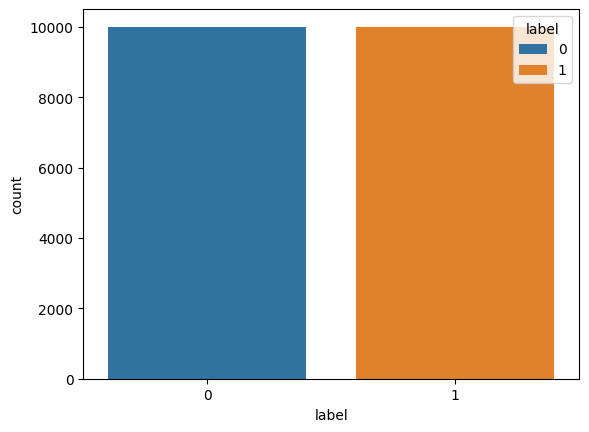

The percentage of Non-Sarcastic comments is 50.0
The percentage of Sarcastic comments is 50.0


In [8]:
import seaborn as sns
sns.countplot(x="label",data=df,hue="label")
plt.show()
print("The percentage of Non-Sarcastic comments is",sum(df['label']==0)/(len(df['label']))*100)
print("The percentage of Sarcastic comments is",sum(df['label']==1)/(len(df['label']))*100)

We can see from the countplot that this dataset is balanced

In [9]:
def clean_text(comment):

    # Cleaning the text by removing links, usernames, HTML tags, expansion of words, username removal, etc.
    text = str(comment)

    # Remove URLs
    text = re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\), ]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', ' ', text)

    # Remove HTML tags
    text = re.sub("<.*?>", " ", text)

    # Remove numbers
    text = re.sub(r"[0-9]+", " ", text)

    # Remove reddit handles
    text = re.sub(r"@[A-Za-z0-9]+", " ", text)

    # Replace contractions
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"can\'t", "can not", text)
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)

    # Remove special characters
    text = text.replace('\\r', ' ')
    text = text.replace('\\"', ' ')
    text = text.replace('\\n', ' ')

    return text

# Apply text cleaning on comment and parent comment
df["cleanV1_comment"] = df["comment"].apply(clean_text)
df["cleanV1_parent_comment"] = df["parent_comment"].apply(clean_text)


In [10]:
df.head(5)

,label,comment,author,score,created_utc,parent_comment,cleanV1_comment,cleanV1_parent_comment
0,0,Although mill decks would love to see you play...,Zerotan,2,2015-07-23 19:38:00,"Correct me if I'm mistaken, but this card turn...",Although mill decks would love to see you play...,"Correct me if I am mistaken, but this card tur..."
1,1,you just have one of those faces i guess,Rollingten,1,2013-04-29 19:33:39,how you think you can discern that is beyond me,you just have one of those faces i guess,how you think you can discern that is beyond me
2,1,"Thanks Samsung, we really needed this in the w...",ProGamerGov,12,2014-09-16 20:50:15,Who goes there? Samsung unveils robot sentry t...,"Thanks Samsung, we really needed this in the w...",Who goes there? Samsung unveils robot sentry t...
3,1,I still think Lloyd McClendon somehow wins it ...,SaddestClown,7,2015-08-31 00:20:45,"If the Rangers win the division, Banister HAS ...",I still think Lloyd McClendon somehow wins it ...,"If the Rangers win the division, Banister HAS ..."
4,0,That was actually completely unintentional.,virulentArachnid,1,2014-07-21 10:16:39,I see what you did there.,That was actually completely unintentional.,I see what you did there.


In [11]:
#function to lowercase all except all caps word
def lowercase_except_caps(sentence):
  #print(sentence)
  words = sentence.split()
  modified_words = []
  for word in words:
    if word.isupper():
      modified_words.append(word)
    else:
      modified_words.append(word.lower())
  return " ".join(modified_words)

**Abbreviation Replacement**


In [12]:
#csv to dataframe
abbrslang=pd.read_csv(r'/content/drive/MyDrive/AML 2304/Abbr.csv')
abbrslang

,Abbr,Meaning
0,@TEOTD,At the end of the day
1,143,I love you
2,2G2BT,Too good to be true
3,404,I don't know
4,4EAE,Forever and ever
...,...,...
426,BS,Bullshit
427,NYC,New York City
428,VR,Virtual Reality
429,GTA,Grand Theft Auto


In [13]:
abbrslangDict=abbrslang.to_dict(orient='records')

In [14]:
import re
def expand_abbr(text, abbr_dict):
    # Regex for 2 or more capital letters (excluding common abbreviations)
    pattern1 = r"\b([A-Z]{2,}(?!\.[A-Z]{2,}))\b"

    # Regex for common abbreviations (Mr., Mrs., etc.)
    pattern2 = r"\b([A-Z]{2,}\.?)\b"

    # Combine both patterns
    combined_pattern = re.compile("|".join([pattern1, pattern2]))

    detected_abbr = []  # List to store detected abbreviations

    def expand_match(match):
        matched_abbr = match.group()
        detected_abbr.append(matched_abbr)  # Store detected abbreviation
        for entry in abbr_dict:
            if matched_abbr.upper() == entry['Abbr']:
                return entry['Meaning']
        return matched_abbr  # Use default if not found

    if not isinstance(text, str):
        text = str(text)  # Convert non-string inputs to strings

    expanded_text = combined_pattern.sub(expand_match, text)

    return expanded_text, detected_abbr

df['abbr_comment'], df['detected_abbr'] = zip(*df['cleanV1_comment'].apply(expand_abbr, args=(abbrslangDict,)))
df['abbr_parent_comment'], df['detected_parent_abbr'] = zip(*df['cleanV1_parent_comment'].apply(expand_abbr, args=(abbrslangDict,)))
df.head(5)

,label,comment,author,score,created_utc,parent_comment,cleanV1_comment,cleanV1_parent_comment,abbr_comment,detected_abbr,abbr_parent_comment,detected_parent_abbr
0,0,Although mill decks would love to see you play...,Zerotan,2,2015-07-23 19:38:00,"Correct me if I'm mistaken, but this card turn...",Although mill decks would love to see you play...,"Correct me if I am mistaken, but this card tur...",Although mill decks would love to see you play...,[],"Correct me if I am mistaken, but this card tur...",[]
1,1,you just have one of those faces i guess,Rollingten,1,2013-04-29 19:33:39,how you think you can discern that is beyond me,you just have one of those faces i guess,how you think you can discern that is beyond me,you just have one of those faces i guess,[],how you think you can discern that is beyond me,[]
2,1,"Thanks Samsung, we really needed this in the w...",ProGamerGov,12,2014-09-16 20:50:15,Who goes there? Samsung unveils robot sentry t...,"Thanks Samsung, we really needed this in the w...",Who goes there? Samsung unveils robot sentry t...,"Thanks Samsung, we really needed this in the w...",[],Who goes there? Samsung unveils robot sentry t...,[]
3,1,I still think Lloyd McClendon somehow wins it ...,SaddestClown,7,2015-08-31 00:20:45,"If the Rangers win the division, Banister HAS ...",I still think Lloyd McClendon somehow wins it ...,"If the Rangers win the division, Banister HAS ...",I still think Lloyd McClendon somehow wins it ...,[],"If the Rangers win the division, Banister HAS ...","[HAS, AL]"
4,0,That was actually completely unintentional.,virulentArachnid,1,2014-07-21 10:16:39,I see what you did there.,That was actually completely unintentional.,I see what you did there.,That was actually completely unintentional.,[],I see what you did there.,[]


In [15]:
from collections import Counter
import pandas as pd

# Flatten the list of lists from detected_abbr and detected_parent_abbr columns into separate lists
detected_abbr_flat = [word for sublist in df['detected_abbr'] if sublist for word in sublist]
detected_parent_abbr_flat = [word for sublist in df['detected_parent_abbr'] if sublist for word in sublist]

# Count the frequency of each word in detected_abbr and detected_parent_abbr
abbr_freq = Counter(detected_abbr_flat)
parent_abbr_freq = Counter(detected_parent_abbr_flat)

# Convert the Counter objects to DataFrames
abbr_freq_df = pd.DataFrame.from_dict(abbr_freq, orient='index', columns=['abbr_comment_freq'])
parent_abbr_freq_df = pd.DataFrame.from_dict(parent_abbr_freq, orient='index', columns=['parent_abbr_comment_freq'])

# Reset the index to make the 'word' a column
abbr_freq_df.reset_index(inplace=True)
parent_abbr_freq_df.reset_index(inplace=True)

# Rename the 'index' column to 'comment_abbr' and 'parent_comment_abbr'
abbr_freq_df.rename(columns={'index': 'comment_abbr'}, inplace=True)
parent_abbr_freq_df.rename(columns={'index': 'parent_comment_abbr'}, inplace=True)

# Save the DataFrames to a CSV file
output_df = pd.concat([abbr_freq_df, parent_abbr_freq_df], axis=1)
output_df.to_csv('/content/drive/MyDrive/AML 2304/Abbr_word_frequency.csv', index=False)

In [16]:
df.to_csv('/content/drive/MyDrive/AML 2304/Abbr_log.csv', index=False)

In [17]:
df.head(5)

,label,comment,author,score,created_utc,parent_comment,cleanV1_comment,cleanV1_parent_comment,abbr_comment,detected_abbr,abbr_parent_comment,detected_parent_abbr
0,0,Although mill decks would love to see you play...,Zerotan,2,2015-07-23 19:38:00,"Correct me if I'm mistaken, but this card turn...",Although mill decks would love to see you play...,"Correct me if I am mistaken, but this card tur...",Although mill decks would love to see you play...,[],"Correct me if I am mistaken, but this card tur...",[]
1,1,you just have one of those faces i guess,Rollingten,1,2013-04-29 19:33:39,how you think you can discern that is beyond me,you just have one of those faces i guess,how you think you can discern that is beyond me,you just have one of those faces i guess,[],how you think you can discern that is beyond me,[]
2,1,"Thanks Samsung, we really needed this in the w...",ProGamerGov,12,2014-09-16 20:50:15,Who goes there? Samsung unveils robot sentry t...,"Thanks Samsung, we really needed this in the w...",Who goes there? Samsung unveils robot sentry t...,"Thanks Samsung, we really needed this in the w...",[],Who goes there? Samsung unveils robot sentry t...,[]
3,1,I still think Lloyd McClendon somehow wins it ...,SaddestClown,7,2015-08-31 00:20:45,"If the Rangers win the division, Banister HAS ...",I still think Lloyd McClendon somehow wins it ...,"If the Rangers win the division, Banister HAS ...",I still think Lloyd McClendon somehow wins it ...,[],"If the Rangers win the division, Banister HAS ...","[HAS, AL]"
4,0,That was actually completely unintentional.,virulentArachnid,1,2014-07-21 10:16:39,I see what you did there.,That was actually completely unintentional.,I see what you did there.,That was actually completely unintentional.,[],I see what you did there.,[]


# Slang Handling

In [18]:
import pandas as pd

# Load the CSV file into a DataFrame
slangs_df = pd.read_csv('/content/drive/MyDrive/AML 2304/Slangs.csv')

# Create a dictionary from the DataFrame
slangs_dict = dict(zip(slangs_df['slangs'], slangs_df['meanings']))

# Function to replace slangs in a sentence and store detected slangs
def replace_slangs(sentence):
    words = sentence.split()
    replaced_words = []
    detected_slangs = []
    for word in words:
        meaning = slangs_dict.get(word, word)
        if meaning != word:
            detected_slangs.append((word, meaning))
        replaced_words.append(meaning)
    return ' '.join(replaced_words), detected_slangs

df['slang_comment'], df['detected_slangs'] = zip(*df['abbr_comment'].apply(replace_slangs))
df['slang_parent_comment'], df['detected_parent_slangs'] = zip(*df['abbr_parent_comment'].apply(replace_slangs))

# Display the updated DataFrame
df.tail(10)

,label,comment,author,score,created_utc,parent_comment,cleanV1_comment,cleanV1_parent_comment,abbr_comment,detected_abbr,abbr_parent_comment,detected_parent_abbr,slang_comment,detected_slangs,slang_parent_comment,detected_parent_slangs
19990,0,I love fisting creepers.,Omnisophic,2,2016-01-05 19:07:26,That is the puss way. A non puss way would jus...,I love fisting creepers.,That is the puss way. A non puss way would jus...,I love fisting creepers.,[],That is the puss way. A non puss way would jus...,[],I love fisting creepers.,[],That is the puss way. A non puss way would jus...,[]
19991,0,If that's the case I'm the Vladimir Putin of FB.,Caligullama,1,2015-07-05 19:38:36,Is this just the international diplomacy equiv...,If that is the case I am the Vladimir Putin of...,Is this just the international diplomacy equiv...,If that is the case I am the Vladimir Putin of...,[FB],Is this just the international diplomacy equiv...,[],If that is the case I am the Vladimir Putin of...,[],Is this just the international diplomacy equiv...,[]
19992,1,My gardener?,Emperor_Twinkie,5,2015-07-13 17:18:03,We need to elect a low-income hispanic female ...,My gardener?,We need to elect a low-income hispanic female ...,My gardener?,[],We need to elect a low-income hispanic female ...,[],My gardener?,[],We need to elect a low-income hispanic female ...,[]
19993,0,Don't see a path to a Bernie victory based on ...,comradebillyboy,5,2016-03-27 19:22:03,Bernie Sanders path to victory ?,Do not see a path to a Bernie victory based on...,Bernie Sanders path to victory ?,Do not see a path to a Bernie victory based on...,[],Bernie Sanders path to victory ?,[],Do not see a path to a Bernie victory based on...,[],Bernie Sanders path to victory ?,[]
19994,1,Dave?,velinxs,1,2016-08-21 17:42:02,"Can confirm, scared to share my opinions aroun...",Dave?,"Can confirm, scared to share my opinions aroun...",Dave?,[],"Can confirm, scared to share my opinions aroun...",[],Dave?,[],"Can confirm, scared to share my opinions aroun...",[]
19995,0,Venting all the way *vent vent vent*,iElectricLewis,15,2016-11-15 08:03:28,over the hills we vent,Venting all the way *vent vent vent*,over the hills we vent,Venting all the way *vent vent vent*,[],over the hills we vent,[],Venting all the way *vent vent vent*,[],over the hills we vent,[]
19996,0,"LOL, wow.",TooPoetic,2,2016-12-22 23:15:42,That's quite literally what they believe. 76 (...,"LOL, wow.",That is quite literally what they believe. (...,"Laughing out loud, wow.",[LOL],That is quite literally what they believe. (...,[],"Laughing out loud, wow.",[],That is quite literally what they believe. (or...,[]
19997,1,"Wow, he's so smart.",llortoftrolls,4,2016-05-10 22:17:36,Roger Ver: Paypal 2.0 Is An Acceptable Risk Fo...,"Wow, he is so smart.",Roger Ver: Paypal . Is An Acceptable Risk Fo...,"Wow, he is so smart.",[],Roger Ver: Paypal . Is An Acceptable Risk Fo...,[],"Wow, he is so smart.",[],Roger Ver: Paypal . Is An Acceptable Risk For ...,[]
19998,1,Yeah because it's really difficult to get guns...,AK47Uprising,14,2014-07-20 14:04:45,BREAKING: California Gov. Jerry Brown Signs Ne...,Yeah because it is really difficult to get gun...,BREAKING: California Gov. Jerry Brown Signs Ne...,Yeah because it is really difficult to get gun...,[],BREAKING: California Gov. Jerry Brown Signs Ne...,"[BREAKING, AB]",Yeah because it is really difficult to get gun...,[],BREAKING: California Gov. Jerry Brown Signs Ne...,[]
19999,0,Cat.,MistaJay2,8,2015-05-30 20:05:36,Cat.,Cat.,Cat.,Cat.,[],Cat.,[],Cat.,[],Cat.,[]


In [19]:
from collections import Counter
import pandas as pd

# Flatten the list of lists from detected_slangs and detected_parent_slangs columns into separate lists
detected_slang_flat = [word for sublist in df['detected_slangs'] if sublist for word in sublist]
detected_parent_slang_flat = [word for sublist in df['detected_parent_slangs'] if sublist for word in sublist]

# Count the frequency of each word in detected_slangs and detected_parent_slangs
slang_freq = Counter(detected_slang_flat)
parent_slang_freq = Counter(detected_parent_slang_flat)

# Convert the Counter objects to DataFrames
slang_freq_df = pd.DataFrame.from_dict(slang_freq, orient='index', columns=['slang_comment_freq'])
parent_slang_freq_df = pd.DataFrame.from_dict(parent_slang_freq, orient='index', columns=['parent_slang_comment_freq'])

# Reset the index to make the 'word' a column
slang_freq_df.reset_index(inplace=True)
parent_slang_freq_df.reset_index(inplace=True)

# Rename the 'index' column to 'comment_slangs' and 'parent_comment_slangs'
slang_freq_df.rename(columns={'index': 'comment_slangs'}, inplace=True)
parent_slang_freq_df.rename(columns={'index': 'parent_comment_slangs'}, inplace=True)

# Save the DataFrames to a CSV file
output_df = pd.concat([slang_freq_df, parent_slang_freq_df], axis=1)
output_df.to_csv('/content/drive/MyDrive/AML 2304/Slang_word_frequency.csv', index=False)

In [20]:
df.to_csv('/content/drive/MyDrive/AML 2304/Slang_log.csv', index=False)

In [21]:
df.head(5)

,label,comment,author,score,created_utc,parent_comment,cleanV1_comment,cleanV1_parent_comment,abbr_comment,detected_abbr,abbr_parent_comment,detected_parent_abbr,slang_comment,detected_slangs,slang_parent_comment,detected_parent_slangs
0,0,Although mill decks would love to see you play...,Zerotan,2,2015-07-23 19:38:00,"Correct me if I'm mistaken, but this card turn...",Although mill decks would love to see you play...,"Correct me if I am mistaken, but this card tur...",Although mill decks would love to see you play...,[],"Correct me if I am mistaken, but this card tur...",[],Although mill decks would love to see you play...,[],"Correct me if I am mistaken, but this card tur...",[]
1,1,you just have one of those faces i guess,Rollingten,1,2013-04-29 19:33:39,how you think you can discern that is beyond me,you just have one of those faces i guess,how you think you can discern that is beyond me,you just have one of those faces i guess,[],how you think you can discern that is beyond me,[],you just have one of those faces i guess,[],how you think you can discern that is beyond me,[]
2,1,"Thanks Samsung, we really needed this in the w...",ProGamerGov,12,2014-09-16 20:50:15,Who goes there? Samsung unveils robot sentry t...,"Thanks Samsung, we really needed this in the w...",Who goes there? Samsung unveils robot sentry t...,"Thanks Samsung, we really needed this in the w...",[],Who goes there? Samsung unveils robot sentry t...,[],"Thanks Samsung, we really needed this in the w...",[],Who goes there? Samsung unveils robot sentry t...,[]
3,1,I still think Lloyd McClendon somehow wins it ...,SaddestClown,7,2015-08-31 00:20:45,"If the Rangers win the division, Banister HAS ...",I still think Lloyd McClendon somehow wins it ...,"If the Rangers win the division, Banister HAS ...",I still think Lloyd McClendon somehow wins it ...,[],"If the Rangers win the division, Banister HAS ...","[HAS, AL]",I still think Lloyd McClendon somehow wins it ...,[],"If the Rangers win the division, Banister HAS ...",[]
4,0,That was actually completely unintentional.,virulentArachnid,1,2014-07-21 10:16:39,I see what you did there.,That was actually completely unintentional.,I see what you did there.,That was actually completely unintentional.,[],I see what you did there.,[],That was actually completely unintentional.,[],I see what you did there.,[]


In [22]:
from nltk.tokenize import word_tokenize
nltk.download('punkt')
import string

# Remove punctuation marks
df['punct_comment'] = df['slang_comment'].apply(lambda x: ''.join([char for char in x if char not in string.punctuation or char in ['?', '!','...']]))
df['punct_parent_comment'] = df['slang_parent_comment'].apply(lambda x: ''.join([char for char in x if char not in string.punctuation or char in ['?', '!','...']]))
# Tokenize the text
df['tokenized_comment'] = df['punct_comment'].apply(lambda x: word_tokenize(x))
df['tokenized_parent_comment'] = df['punct_parent_comment'].apply(lambda x: word_tokenize(x))


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [23]:
df.head(10)

,label,comment,author,score,created_utc,parent_comment,cleanV1_comment,cleanV1_parent_comment,abbr_comment,detected_abbr,abbr_parent_comment,detected_parent_abbr,slang_comment,detected_slangs,slang_parent_comment,detected_parent_slangs,punct_comment,punct_parent_comment,tokenized_comment,tokenized_parent_comment
0,0,Although mill decks would love to see you play...,Zerotan,2,2015-07-23 19:38:00,"Correct me if I'm mistaken, but this card turn...",Although mill decks would love to see you play...,"Correct me if I am mistaken, but this card tur...",Although mill decks would love to see you play...,[],"Correct me if I am mistaken, but this card tur...",[],Although mill decks would love to see you play...,[],"Correct me if I am mistaken, but this card tur...",[],Although mill decks would love to see you play...,Correct me if I am mistaken but this card turn...,"[Although, mill, decks, would, love, to, see, ...","[Correct, me, if, I, am, mistaken, but, this, ..."
1,1,you just have one of those faces i guess,Rollingten,1,2013-04-29 19:33:39,how you think you can discern that is beyond me,you just have one of those faces i guess,how you think you can discern that is beyond me,you just have one of those faces i guess,[],how you think you can discern that is beyond me,[],you just have one of those faces i guess,[],how you think you can discern that is beyond me,[],you just have one of those faces i guess,how you think you can discern that is beyond me,"[you, just, have, one, of, those, faces, i, gu...","[how, you, think, you, can, discern, that, is,..."
2,1,"Thanks Samsung, we really needed this in the w...",ProGamerGov,12,2014-09-16 20:50:15,Who goes there? Samsung unveils robot sentry t...,"Thanks Samsung, we really needed this in the w...",Who goes there? Samsung unveils robot sentry t...,"Thanks Samsung, we really needed this in the w...",[],Who goes there? Samsung unveils robot sentry t...,[],"Thanks Samsung, we really needed this in the w...",[],Who goes there? Samsung unveils robot sentry t...,[],Thanks Samsung we really needed this in the wo...,Who goes there? Samsung unveils robot sentry t...,"[Thanks, Samsung, we, really, needed, this, in...","[Who, goes, there, ?, Samsung, unveils, robot,..."
3,1,I still think Lloyd McClendon somehow wins it ...,SaddestClown,7,2015-08-31 00:20:45,"If the Rangers win the division, Banister HAS ...",I still think Lloyd McClendon somehow wins it ...,"If the Rangers win the division, Banister HAS ...",I still think Lloyd McClendon somehow wins it ...,[],"If the Rangers win the division, Banister HAS ...","[HAS, AL]",I still think Lloyd McClendon somehow wins it ...,[],"If the Rangers win the division, Banister HAS ...",[],I still think Lloyd McClendon somehow wins it ...,If the Rangers win the division Banister HAS t...,"[I, still, think, Lloyd, McClendon, somehow, w...","[If, the, Rangers, win, the, division, Baniste..."
4,0,That was actually completely unintentional.,virulentArachnid,1,2014-07-21 10:16:39,I see what you did there.,That was actually completely unintentional.,I see what you did there.,That was actually completely unintentional.,[],I see what you did there.,[],That was actually completely unintentional.,[],I see what you did there.,[],That was actually completely unintentional,I see what you did there,"[That, was, actually, completely, unintentional]","[I, see, what, you, did, there]"
5,0,Cardinals fan?,XC_Stallion92,2,2014-10-30 04:29:02,"As my friend says, you haven't experienced pai...",Cardinals fan?,"As my friend says, you have not experienced pa...",Cardinals fan?,[],"As my friend says, you have not experienced pa...",[],Cardinals fan?,[],"As my friend says, you have not experienced pa...",[],Cardinals fan?,As my friend says you have not experienced pai...,"[Cardinals, fan, ?]","[As, my, friend, says, you, have, not, experie..."
6,0,The thing though is that the SPJ is only conce...,Helium_Pugilist,2,2015-05-08 10:43:09,"First of all, if you go through the panelists ...",The 

In [24]:
import emoji
# Function to check if a string contains emojis
def has_emoji(text):
    #text = str(text)
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F700-\U0001F77F"  # alchemical symbols
                               u"\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
                               u"\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
                               u"\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
                               u"\U0001FA00-\U0001FA6F"  # Chess Symbols
                               u"\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
                               u"\U00002702-\U000027B0"  # Dingbats
                               u"\U000024C2-\U0001F251"
                               "]+", flags=re.UNICODE)
    return bool(emoji_pattern.search(text))

# Function to replace emojis with their meanings
def replace_emojis(text):
    return emoji.demojize(text)

# Apply emoji replacement and check for emojis
df["has_emoji"] = df["tokenized_comment"].astype(str).apply(has_emoji)
df["has_emoji_parent"] = df["tokenized_parent_comment"].astype(str).apply(has_emoji)

# Apply emoji replacement and create a pandas Series
emoji_replaced_series = df["tokenized_comment"].astype(str).apply(replace_emojis)
emoji_replaced_series_parent = df["tokenized_parent_comment"].astype(str).apply(replace_emojis)

# Assign the pandas Series to the DataFrame as a new column
df["emoji_replaced_comment"] = emoji_replaced_series
df["emoji_replaced_parent_comment"] = emoji_replaced_series_parent
print(type(df['emoji_replaced_comment']))
print(type(df['emoji_replaced_parent_comment']))

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>


In [25]:
print(df['has_emoji'].value_counts()[False])
print(df['has_emoji_parent'].value_counts()[False])

20000
20000


**This upper value is same as the total number of comments, which shows that we don't have any emojis in the dataset**

In [26]:
df.head(5)

,label,comment,author,score,created_utc,parent_comment,cleanV1_comment,cleanV1_parent_comment,abbr_comment,detected_abbr,...,slang_parent_comment,detected_parent_slangs,punct_comment,punct_parent_comment,tokenized_comment,tokenized_parent_comment,has_emoji,has_emoji_parent,emoji_replaced_comment,emoji_replaced_parent_comment
0,0,Although mill decks would love to see you play...,Zerotan,2,2015-07-23 19:38:00,"Correct me if I'm mistaken, but this card turn...",Although mill decks would love to see you play...,"Correct me if I am mistaken, but this card tur...",Although mill decks would love to see you play...,[],...,"Correct me if I am mistaken, but this card tur...",[],Although mill decks would love to see you play...,Correct me if I am mistaken but this card turn...,"[Although, mill, decks, would, love, to, see, ...","[Correct, me, if, I, am, mistaken, but, this, ...",False,False,"['Although', 'mill', 'decks', 'would', 'love',...","['Correct', 'me', 'if', 'I', 'am', 'mistaken',..."
1,1,you just have one of those faces i guess,Rollingten,1,2013-04-29 19:33:39,how you think you can discern that is beyond me,you just have one of those faces i guess,how you think you can discern that is beyond me,you just have one of those faces i guess,[],...,how you think you can discern that is beyond me,[],you just have one of those faces i guess,how you think you can discern that is beyond me,"[you, just, have, one, of, those, faces, i, gu...","[how, you, think, you, can, discern, that, is,...",False,False,"['you', 'just', 'have', 'one', 'of', 'those', ...","['how', 'you', 'think', 'you', 'can', 'discern..."
2,1,"Thanks Samsung, we really needed this in the w...",ProGamerGov,12,2014-09-16 20:50:15,Who goes there? Samsung unveils robot sentry t...,"Thanks Samsung, we really needed this in the w...",Who goes there? Samsung unveils robot sentry t...,"Thanks Samsung, we really needed this in the w...",[],...,Who goes there? Samsung unveils robot sentry t...,[],Thanks Samsung we really needed this in the wo...,Who goes there? Samsung unveils robot sentry t...,"[Thanks, Samsung, we, really, needed, this, in...","[Who, goes, there, ?, Samsung, unveils, robot,...",False,False,"['Thanks', 'Samsung', 'we', 'really', 'needed'...","['Who', 'goes', 'there', '?', 'Samsung', 'unve..."
3,1,I still think Lloyd McClendon somehow wins it ...,SaddestClown,7,2015-08-31 00:20:45,"If the Rangers win the division, Banister HAS ...",I still think Lloyd McClendon somehow wins it ...,"If the Rangers win the division, Banister HAS ...",I still think Lloyd McClendon somehow wins it ...,[],...,"If the Rangers win the division, Banister HAS ...",[],I still think Lloyd McClendon somehow wins it ...,If the Rangers win the division Banister HAS t...,"[I, still, think, Lloyd, McClendon, somehow, w...","[If, the, Rangers, win, the, division, Baniste...",False,False,"['I', 'still', 'think', 'Lloyd', 'McClendon', ...","['If', 'the', 'Rangers', 'win', 'the', 'divisi..."
4,0,That was actually completely unintentional.,virulentArachnid,1,2014-07-21 10:16:39,I see what you did there.,That was actually completely unintentional.,I see what you did there.,That was actually completely unintentional.,[],...,I see what you did there.,[],That was actually completely unintentional,I see what you did there,"[That, was, actually, completely, unintentional]","[I, see, what, you, did, there]",False,False,"['That', 'was', 'actually', 'completely', 'uni...","['I', 'see', 'what', 'you', 'did', 'there']"


**Lowercasing the tokenized comments and parent comments**

In [27]:
# Apply the lowercase_except_caps function to 'emoji_replaced_comment' column
df['lowered_comment'] = df['emoji_replaced_comment'].apply(lowercase_except_caps)

# Apply the lowercase_except_caps function to 'emoji_replaced_parent_comment' column
df['lowered_parent_comment'] = df['emoji_replaced_parent_comment'].apply(lowercase_except_caps)

In [28]:
df.head(5)

,label,comment,author,score,created_utc,parent_comment,cleanV1_comment,cleanV1_parent_comment,abbr_comment,detected_abbr,...,punct_comment,punct_parent_comment,tokenized_comment,tokenized_parent_comment,has_emoji,has_emoji_parent,emoji_replaced_comment,emoji_replaced_parent_comment,lowered_comment,lowered_parent_comment
0,0,Although mill decks would love to see you play...,Zerotan,2,2015-07-23 19:38:00,"Correct me if I'm mistaken, but this card turn...",Although mill decks would love to see you play...,"Correct me if I am mistaken, but this card tur...",Although mill decks would love to see you play...,[],...,Although mill decks would love to see you play...,Correct me if I am mistaken but this card turn...,"[Although, mill, decks, would, love, to, see, ...","[Correct, me, if, I, am, mistaken, but, this, ...",False,False,"['Although', 'mill', 'decks', 'would', 'love',...","['Correct', 'me', 'if', 'I', 'am', 'mistaken',...","['although', 'mill', 'decks', 'would', 'love',...","['correct', 'me', 'if', 'I', 'am', 'mistaken',..."
1,1,you just have one of those faces i guess,Rollingten,1,2013-04-29 19:33:39,how you think you can discern that is beyond me,you just have one of those faces i guess,how you think you can discern that is beyond me,you just have one of those faces i guess,[],...,you just have one of those faces i guess,how you think you can discern that is beyond me,"[you, just, have, one, of, those, faces, i, gu...","[how, you, think, you, can, discern, that, is,...",False,False,"['you', 'just', 'have', 'one', 'of', 'those', ...","['how', 'you', 'think', 'you', 'can', 'discern...","['you', 'just', 'have', 'one', 'of', 'those', ...","['how', 'you', 'think', 'you', 'can', 'discern..."
2,1,"Thanks Samsung, we really needed this in the w...",ProGamerGov,12,2014-09-16 20:50:15,Who goes there? Samsung unveils robot sentry t...,"Thanks Samsung, we really needed this in the w...",Who goes there? Samsung unveils robot sentry t...,"Thanks Samsung, we really needed this in the w...",[],...,Thanks Samsung we really needed this in the wo...,Who goes there? Samsung unveils robot sentry t...,"[Thanks, Samsung, we, really, needed, this, in...","[Who, goes, there, ?, Samsung, unveils, robot,...",False,False,"['Thanks', 'Samsung', 'we', 'really', 'needed'...","['Who', 'goes', 'there', '?', 'Samsung', 'unve...","['thanks', 'samsung', 'we', 'really', 'needed'...","['who', 'goes', 'there', '?', 'samsung', 'unve..."
3,1,I still think Lloyd McClendon somehow wins it ...,SaddestClown,7,2015-08-31 00:20:45,"If the Rangers win the division, Banister HAS ...",I still think Lloyd McClendon somehow wins it ...,"If the Rangers win the division, Banister HAS ...",I still think Lloyd McClendon somehow wins it ...,[],...,I still think Lloyd McClendon somehow wins it ...,If the Rangers win the division Banister HAS t...,"[I, still, think, Lloyd, McClendon, somehow, w...","[If, the, Rangers, win, the, division, Baniste...",False,False,"['I', 'still', 'think', 'Lloyd', 'McClendon', ...","['If', 'the', 'Rangers', 'win', 'the', 'divisi...","['I', 'still', 'think', 'lloyd', 'mcclendon', ...","['if', 'the', 'rangers', 'win', 'the', 'divisi..."
4,0,That was actually completely unintentional.,virulentArachnid,1,2014-07-21 10:16:39,I see what you did there.,That was actually completely unintentional.,I see what you did there.,That was actually completely unintentional.,[],...,That was actually completely unintentional,I see what you did there,"[That, was, actually, completely, unintentional]","[I, see, what, you, did, there]",False,False,"['That', 'was', 'actually', 'completely', 'uni...","['I', 'see', 'what', 'you', 'did', 'there']","['that', 'was', 'actually', 'completely', 'uni...","['I', 'see', 'what', 'you', 'did', 'there']"


**Stop words removal**

In [29]:
import ast
from nltk.corpus import stopwords

# Import stopwords and define custom set
stops = set(stopwords.words('english')) - {'no', 'not', 'nor', 'against', 'above', 'below', 'off', 'own'}

# Apply stopword removal to the emoji_replaced_comment column
def remove_stopwords(comment):
    return [word for word in ast.literal_eval(comment) if word.lower() not in stops]

df["cleaned_comment"] = df["lowered_comment"].apply(remove_stopwords)
df["cleaned_parent_comment"] = df["lowered_parent_comment"].apply(remove_stopwords)

In [30]:
df.head(5)

,label,comment,author,score,created_utc,parent_comment,cleanV1_comment,cleanV1_parent_comment,abbr_comment,detected_abbr,...,tokenized_comment,tokenized_parent_comment,has_emoji,has_emoji_parent,emoji_replaced_comment,emoji_replaced_parent_comment,lowered_comment,lowered_parent_comment,cleaned_comment,cleaned_parent_comment
0,0,Although mill decks would love to see you play...,Zerotan,2,2015-07-23 19:38:00,"Correct me if I'm mistaken, but this card turn...",Although mill decks would love to see you play...,"Correct me if I am mistaken, but this card tur...",Although mill decks would love to see you play...,[],...,"[Although, mill, decks, would, love, to, see, ...","[Correct, me, if, I, am, mistaken, but, this, ...",False,False,"['Although', 'mill', 'decks', 'would', 'love',...","['Correct', 'me', 'if', 'I', 'am', 'mistaken',...","['although', 'mill', 'decks', 'would', 'love',...","['correct', 'me', 'if', 'I', 'am', 'mistaken',...","[although, mill, decks, would, love, see, play]","[correct, mistaken, card, turns, deck, card, o..."
1,1,you just have one of those faces i guess,Rollingten,1,2013-04-29 19:33:39,how you think you can discern that is beyond me,you just have one of those faces i guess,how you think you can discern that is beyond me,you just have one of those faces i guess,[],...,"[you, just, have, one, of, those, faces, i, gu...","[how, you, think, you, can, discern, that, is,...",False,False,"['you', 'just', 'have', 'one', 'of', 'those', ...","['how', 'you', 'think', 'you', 'can', 'discern...","['you', 'just', 'have', 'one', 'of', 'those', ...","['how', 'you', 'think', 'you', 'can', 'discern...","[one, faces, guess]","[think, discern, beyond]"
2,1,"Thanks Samsung, we really needed this in the w...",ProGamerGov,12,2014-09-16 20:50:15,Who goes there? Samsung unveils robot sentry t...,"Thanks Samsung, we really needed this in the w...",Who goes there? Samsung unveils robot sentry t...,"Thanks Samsung, we really needed this in the w...",[],...,"[Thanks, Samsung, we, really, needed, this, in...","[Who, goes, there, ?, Samsung, unveils, robot,...",False,False,"['Thanks', 'Samsung', 'we', 'really', 'needed'...","['Who', 'goes', 'there', '?', 'Samsung', 'unve...","['thanks', 'samsung', 'we', 'really', 'needed'...","['who', 'goes', 'there', '?', 'samsung', 'unve...","[thanks, samsung, really, needed, world, !]","[goes, ?, samsung, unveils, robot, sentry, kil..."
3,1,I still think Lloyd McClendon somehow wins it ...,SaddestClown,7,2015-08-31 00:20:45,"If the Rangers win the division, Banister HAS ...",I still think Lloyd McClendon somehow wins it ...,"If the Rangers win the division, Banister HAS ...",I still think Lloyd McClendon somehow wins it ...,[],...,"[I, still, think, Lloyd, McClendon, somehow, w...","[If, the, Rangers, win, the, division, Baniste...",False,False,"['I', 'still', 'think', 'Lloyd', 'McClendon', ...","['If', 'the', 'Rangers', 'win', 'the', 'divisi...","['I', 'still', 'think', 'lloyd', 'mcclendon', ...","['if', 'the', 'rangers', 'win', 'the', 'divisi...","[still, think, lloyd, mcclendon, somehow, wins...","[rangers, win, division, banister, get, AL, ma..."
4,0,That was actually completely unintentional.,virulentArachnid,1,2014-07-21 10:16:39,I see what you did there.,That was actually completely unintentional.,I see what you did there.,That was actually completely unintentional.,[],...,"[That, was, actually, completely, unintentional]","[I, see, what, you, did, there]",False,False,"['That', 'was', 'actually', 'completely', 'uni...","['I', 'see', 'what', 'you', 'did', 'there']","['that', 'was', 'actually', 'completely', 'uni...","['I', 'see', 'what', 'you', 'did', 'there']","[actually, completely, unintentional]",[see]


**Cloud Map for highest occuring words in both(sarcastic & non-sarcastic) the categories before cleaning**

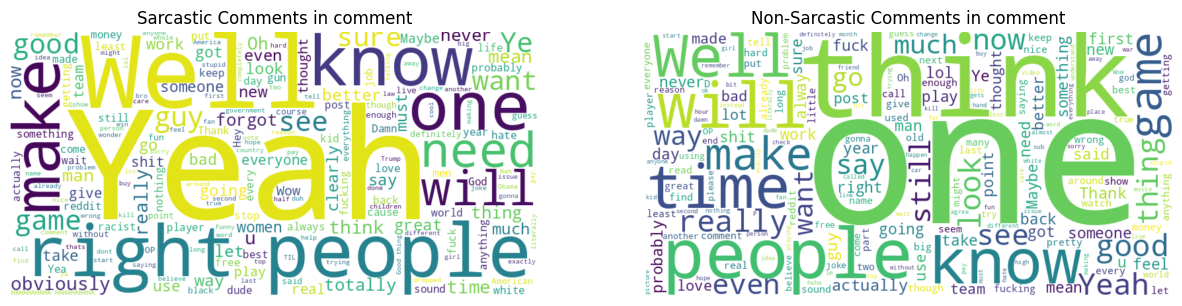

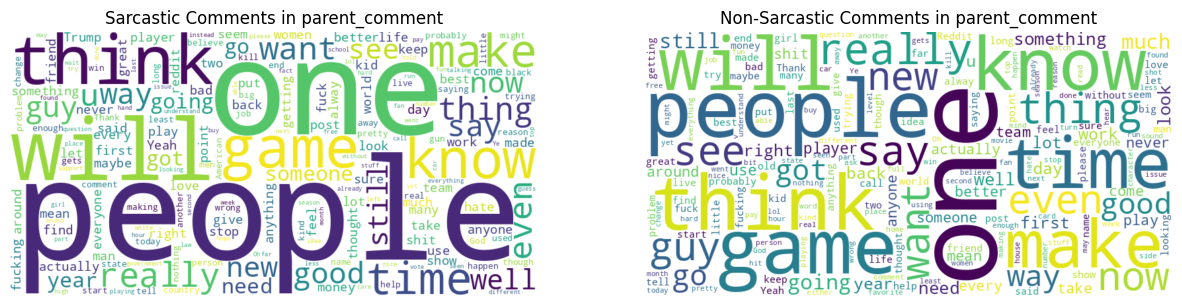

In [31]:
!pip install wordcloud
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Filter sarcastic and non-sarcastic comments in 'comment' column
sarcastic_comments = ' '.join(df[df['label'] == 1]['comment'])
non_sarcastic_comments = ' '.join(df[df['label'] == 0]['comment'])

# Generate word clouds for sarcastic and non-sarcastic comments in 'comment' column
wordcloud_sarcastic = WordCloud(width=800, height=400, background_color='white').generate(sarcastic_comments)
wordcloud_non_sarcastic = WordCloud(width=800, height=400, background_color='white').generate(non_sarcastic_comments)

# Plot the word clouds for 'comment'
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.imshow(wordcloud_sarcastic, interpolation='bilinear')
plt.title('Sarcastic Comments in comment')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_non_sarcastic, interpolation='bilinear')
plt.title('Non-Sarcastic Comments in comment')
plt.axis('off')

plt.show()

# Filter sarcastic and non-sarcastic comments in 'parent_comment' column
sarcastic_parent_comments = ' '.join(df[df['label'] == 1]['parent_comment'])
non_sarcastic_parent_comments = ' '.join(df[df['label'] == 0]['parent_comment'])

# Generate word clouds for sarcastic and non-sarcastic comments in 'parent_comment' column
wordcloud_sarcastic_parent = WordCloud(width=800, height=400, background_color='white').generate(sarcastic_parent_comments)
wordcloud_non_sarcastic_parent = WordCloud(width=800, height=400, background_color='white').generate(non_sarcastic_parent_comments)

# Plot the word clouds for 'parent_comment'
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.imshow(wordcloud_sarcastic_parent, interpolation='bilinear')
plt.title('Sarcastic Comments in parent_comment')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_non_sarcastic_parent, interpolation='bilinear')
plt.title('Non-Sarcastic Comments in parent_comment')
plt.axis('off')

plt.show()

**Cloud Map for highest occuring words in both(sarcastic & non-sarcastic) the categories after cleaning**

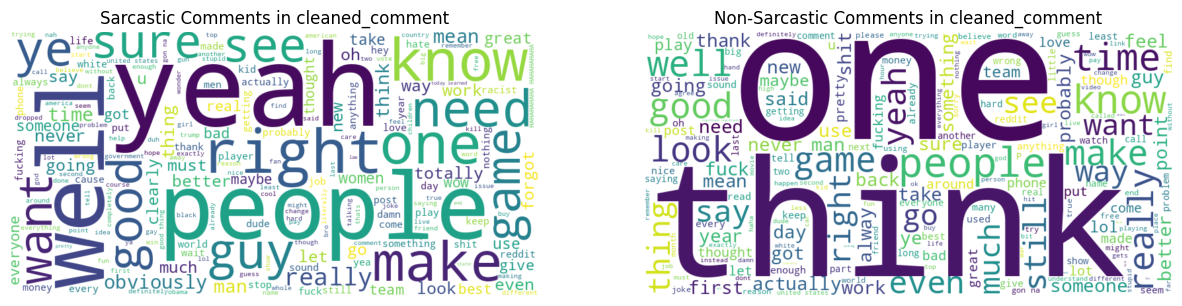

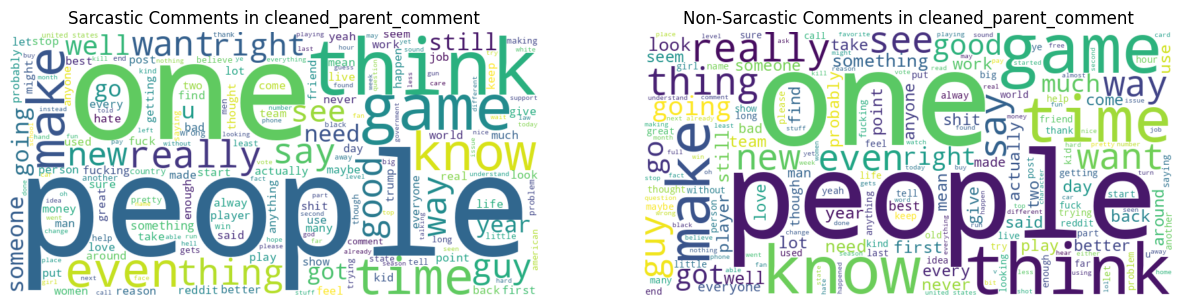

In [32]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Join lists of words in cleaned_comment column to form strings
sarcastic_comments = ' '.join(df[df['label'] == 1]['cleaned_comment'].apply(lambda x: ' '.join(x)))
non_sarcastic_comments = ' '.join(df[df['label'] == 0]['cleaned_comment'].apply(lambda x: ' '.join(x)))

# Generate word clouds for sarcastic and non-sarcastic comments in cleaned_comment
wordcloud_sarcastic = WordCloud(width=800, height=400, background_color='white').generate(sarcastic_comments)
wordcloud_non_sarcastic = WordCloud(width=800, height=400, background_color='white').generate(non_sarcastic_comments)

# Plot the word clouds for cleaned_comment
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.imshow(wordcloud_sarcastic, interpolation='bilinear')
plt.title('Sarcastic Comments in cleaned_comment')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_non_sarcastic, interpolation='bilinear')
plt.title('Non-Sarcastic Comments in cleaned_comment')
plt.axis('off')

plt.show()

# Join lists of words in cleaned_parent_comment column to form strings
sarcastic_parent_comments = ' '.join(df[df['label'] == 1]['cleaned_parent_comment'].apply(lambda x: ' '.join(x)))
non_sarcastic_parent_comments = ' '.join(df[df['label'] == 0]['cleaned_parent_comment'].apply(lambda x: ' '.join(x)))

# Generate word clouds for sarcastic and non-sarcastic comments in cleaned_parent_comment
wordcloud_sarcastic_parent = WordCloud(width=800, height=400, background_color='white').generate(sarcastic_parent_comments)
wordcloud_non_sarcastic_parent = WordCloud(width=800, height=400, background_color='white').generate(non_sarcastic_parent_comments)

# Plot the word clouds for cleaned_parent_comment
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.imshow(wordcloud_sarcastic_parent, interpolation='bilinear')
plt.title('Sarcastic Comments in cleaned_parent_comment')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_non_sarcastic_parent, interpolation='bilinear')
plt.title('Non-Sarcastic Comments in cleaned_parent_comment')
plt.axis('off')

plt.show()

**GloVe Embedding**

In [33]:
import spacy
import numpy as np

# Load SpaCy with GloVe vectors
nlp = spacy.load("en_core_web_md")  # Load the medium-sized English model with GloVe vectors

# Define function to compute average GloVe embeddings for a text
def compute_average_glove_embedding(text, nlp_model):
    doc = nlp_model(' '.join(text))
    # Get vectors for each token in the text
    word_vectors = [token.vector for token in doc if not token.is_stop]
    if word_vectors:
        # Compute average embedding
        average_embedding = np.mean(word_vectors, axis=0)
        return average_embedding
    else:
        # Return zeros if no valid word vectors found
        return np.zeros(nlp_model.vocab.vectors_length)

# Compute average GloVe embeddings for each comment
df['glove_embedding'] = df['cleaned_comment'].apply(lambda x: compute_average_glove_embedding(x, nlp))
df['glove_parent_embedding'] = df['cleaned_parent_comment'].apply(lambda x: compute_average_glove_embedding(x, nlp))

In [34]:
df.head(10)

,label,comment,author,score,created_utc,parent_comment,cleanV1_comment,cleanV1_parent_comment,abbr_comment,detected_abbr,...,has_emoji,has_emoji_parent,emoji_replaced_comment,emoji_replaced_parent_comment,lowered_comment,lowered_parent_comment,cleaned_comment,cleaned_parent_comment,glove_embedding,glove_parent_embedding
0,0,Although mill decks would love to see you play...,Zerotan,2,2015-07-23 19:38:00,"Correct me if I'm mistaken, but this card turn...",Although mill decks would love to see you play...,"Correct me if I am mistaken, but this card tur...",Although mill decks would love to see you play...,[],...,False,False,"['Although', 'mill', 'decks', 'would', 'love',...","['Correct', 'me', 'if', 'I', 'am', 'mistaken',...","['although', 'mill', 'decks', 'would', 'love',...","['correct', 'me', 'if', 'I', 'am', 'mistaken',...","[although, mill, decks, would, love, see, play]","[correct, mistaken, card, turns, deck, card, o...","[-1.8146749, 0.32449996, -2.5036223, -0.191600...","[-1.1494846, 0.99603283, -1.9485236, 0.6356435..."
1,1,you just have one of those faces i guess,Rollingten,1,2013-04-29 19:33:39,how you think you can discern that is beyond me,you just have one of those faces i guess,how you think you can discern that is beyond me,you just have one of those faces i guess,[],...,False,False,"['you', 'just', 'have', 'one', 'of', 'those', ...","['how', 'you', 'think', 'you', 'can', 'discern...","['you', 'just', 'have', 'one', 'of', 'those', ...","['how', 'you', 'think', 'you', 'can', 'discern...","[one, faces, guess]","[think, discern, beyond]","[0.089385, 1.60758, -2.7418895, -1.7537501, 2....","[-0.75512004, 1.55531, -1.64475, -1.24477, -1...."
2,1,"Thanks Samsung, we really needed this in the w...",ProGamerGov,12,2014-09-16 20:50:15,Who goes there? Samsung unveils robot sentry t...,"Thanks Samsung, we really needed this in the w...",Who goes there? Samsung unveils robot sentry t...,"Thanks Samsung, we really needed this in the w...",[],...,False,False,"['Thanks', 'Samsung', 'we', 'really', 'needed'...","['Who', 'goes', 'there', '?', 'Samsung', 'unve...","['thanks', 'samsung', 'we', 'really', 'needed'...","['who', 'goes', 'there', '?', 'samsung', 'unve...","[thanks, samsung, really, needed, world, !]","[goes, ?, samsung, unveils, robot, sentry, kil...","[2.524086, 0.36567402, -1.718602, -1.565164, 3...","[-0.6565856, 1.7325287, -3.032008, -0.15609667..."
3,1,I still think Lloyd McClendon somehow wins it ...,SaddestClown,7,2015-08-31 00:20:45,"If the Rangers win the division, Banister HAS ...",I still think Lloyd McClendon somehow wins it ...,"If the Rangers win the division, Banister HAS ...",I still think Lloyd McClendon somehow wins it ...,[],...,False,False,"['I', 'still', 'think', 'Lloyd', 'McClendon', ...","['If', 'the', 'Rangers', 'win', 'the', 'divisi...","['I', 'still', 'think', 'lloyd', 'mcclendon', ...","['if', 'the', 'rangers', 'win', 'the', 'divisi...","[still, think, lloyd, mcclendon, somehow, wins...","[rangers, win, division, banister, get, AL, ma...","[-0.794985, -0.13094997, -0.32479998, -0.52786...","[-1.8240331, -0.009008884, -0.2520467, -0.4538..."
4,0,That was actually completely unintentional.,virulentArachnid,1,2014-07-21 10:16:39,I see what you did there.,That was actually completely unintentional.,I see what you did there.,That was actually completely unintentional.,[],...,False,False,"['That', 'was', 'actually', 'completely', 'uni...","['I', 'see', 'what', 'you', 'did', 'there']","['that', 'was', 'actually', 'completely', 'uni...","['I', 'see', 'what', 'you', 'did', 'there']","[actually, completely, unintentional]",[see],"[-1.0084432, 0.062649995, -1.5305933, -0.48679...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
5,0,Cardinals fan?,XC_Stallion92,2,2014-10-30 04:29:02,"As my friend says, you haven't experienced pai...",Cardinals fan?,"As my friend says, you have not experienced pa...",Cardinals fan?,[],...,False,False,"['Cardinals', 'fan', '?']","['As', 'my', 'friend', 'says', 'you', 'h

**lemmetization**

In [35]:
# Load the spaCy English language model
nlp = spacy.load("en_core_web_sm")

def lemma(comment):
    # Join the list of words into a single string
    text = ' '.join(comment)
    # Tokenize the text
    words = word_tokenize(text)
    # Lemmatize and remove stopwords
    cleaned_words = [token.lemma_ for token in nlp(' '.join(words)) if token.text not in stops]
    # Join the cleaned words back into a single string
    cleaned_text = ' '.join(cleaned_words)
    return cleaned_text

# Apply lemmatization
df["lemma_comment"] = df["cleaned_comment"].apply(lemma)
df["lemma_parent_comment"] = df["cleaned_parent_comment"].apply(lemma)

In [36]:
df.head(10)

,label,comment,author,score,created_utc,parent_comment,cleanV1_comment,cleanV1_parent_comment,abbr_comment,detected_abbr,...,emoji_replaced_comment,emoji_replaced_parent_comment,lowered_comment,lowered_parent_comment,cleaned_comment,cleaned_parent_comment,glove_embedding,glove_parent_embedding,lemma_comment,lemma_parent_comment
0,0,Although mill decks would love to see you play...,Zerotan,2,2015-07-23 19:38:00,"Correct me if I'm mistaken, but this card turn...",Although mill decks would love to see you play...,"Correct me if I am mistaken, but this card tur...",Although mill decks would love to see you play...,[],...,"['Although', 'mill', 'decks', 'would', 'love',...","['Correct', 'me', 'if', 'I', 'am', 'mistaken',...","['although', 'mill', 'decks', 'would', 'love',...","['correct', 'me', 'if', 'I', 'am', 'mistaken',...","[although, mill, decks, would, love, see, play]","[correct, mistaken, card, turns, deck, card, o...","[-1.8146749, 0.32449996, -2.5036223, -0.191600...","[-1.1494846, 0.99603283, -1.9485236, 0.6356435...",although mill deck would love see play,correct mistaken card turn deck card one card ...
1,1,you just have one of those faces i guess,Rollingten,1,2013-04-29 19:33:39,how you think you can discern that is beyond me,you just have one of those faces i guess,how you think you can discern that is beyond me,you just have one of those faces i guess,[],...,"['you', 'just', 'have', 'one', 'of', 'those', ...","['how', 'you', 'think', 'you', 'can', 'discern...","['you', 'just', 'have', 'one', 'of', 'those', ...","['how', 'you', 'think', 'you', 'can', 'discern...","[one, faces, guess]","[think, discern, beyond]","[0.089385, 1.60758, -2.7418895, -1.7537501, 2....","[-0.75512004, 1.55531, -1.64475, -1.24477, -1....",one face guess,think discern beyond
2,1,"Thanks Samsung, we really needed this in the w...",ProGamerGov,12,2014-09-16 20:50:15,Who goes there? Samsung unveils robot sentry t...,"Thanks Samsung, we really needed this in the w...",Who goes there? Samsung unveils robot sentry t...,"Thanks Samsung, we really needed this in the w...",[],...,"['Thanks', 'Samsung', 'we', 'really', 'needed'...","['Who', 'goes', 'there', '?', 'Samsung', 'unve...","['thanks', 'samsung', 'we', 'really', 'needed'...","['who', 'goes', 'there', '?', 'samsung', 'unve...","[thanks, samsung, really, needed, world, !]","[goes, ?, samsung, unveils, robot, sentry, kil...","[2.524086, 0.36567402, -1.718602, -1.565164, 3...","[-0.6565856, 1.7325287, -3.032008, -0.15609667...",thank samsung really need world !,go ? samsung unveils robot sentry kill two mil...
3,1,I still think Lloyd McClendon somehow wins it ...,SaddestClown,7,2015-08-31 00:20:45,"If the Rangers win the division, Banister HAS ...",I still think Lloyd McClendon somehow wins it ...,"If the Rangers win the division, Banister HAS ...",I still think Lloyd McClendon somehow wins it ...,[],...,"['I', 'still', 'think', 'Lloyd', 'McClendon', ...","['If', 'the', 'Rangers', 'win', 'the', 'divisi...","['I', 'still', 'think', 'lloyd', 'mcclendon', ...","['if', 'the', 'rangers', 'win', 'the', 'divisi...","[still, think, lloyd, mcclendon, somehow, wins...","[rangers, win, division, banister, get, AL, ma...","[-0.794985, -0.13094997, -0.32479998, -0.52786...","[-1.8240331, -0.009008884, -0.2520467, -0.4538...",still think lloyd mcclendon somehow win good s...,ranger win division banister get AL manager ye...
4,0,That was actually completely unintentional.,virulentArachnid,1,2014-07-21 10:16:39,I see what you did there.,That was actually completely unintentional.,I see what you did there.,That was actually completely unintentional.,[],...,"['That', 'was', 'actually', 'completely', 'uni...","['I', 'see', 'what', 'you', 'did', 'there']","['that', 'was', 'actually', 'completely', 'uni...","['I', 'see', 'what', 'you', 'did', 'there']","[actually, completely, unintentional]",[see],"[-1.0084432, 0.062649995, -1.5305933, -0.48679...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",actually completely 

**TF-IDF Vectorization**

In [42]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Create TF-IDF vectorizer for 'lemma_comment'
vectorizer_comment = TfidfVectorizer()
TfIdfMatrix_comment = vectorizer_comment.fit_transform(df["lemma_comment"])
print(TfIdfMatrix_comment)
print("----------------------------------------------------------")
# Create TF-IDF vectorizer for 'lemma_parent_comment'
vectorizer_parent_comment = TfidfVectorizer()
TfIdfMatrix_parent_comment = vectorizer_parent_comment.fit_transform(df["lemma_parent_comment"])
print(TfIdfMatrix_parent_comment)

  (0, 11424)	0.29569429011230725
  (0, 13357)	0.2628749512603334
  (0, 8853)	0.3186175798275102
  (0, 16772)	0.22647290627756295
  (0, 3719)	0.4470740090032808
  (0, 9530)	0.525449254209401
  (0, 447)	0.46333834189113804
  (1, 6454)	0.6038473386308716
  (1, 5168)	0.6621112940355313
  (1, 10619)	0.4438209390497568
  (2, 16751)	0.42101992157434837
  (2, 10074)	0.3426215007975448
  (2, 12321)	0.34386549091285235
  (2, 13105)	0.6621406521137182
  (2, 15035)	0.3855891775017169
  (3, 14238)	0.3642389607782723
  (3, 6254)	0.21491960808254493
  (3, 16634)	0.30392954078065093
  (3, 14062)	0.3821972387453312
  (3, 9263)	0.4934849644303099
  (3, 8743)	0.4738881686969988
  (3, 15097)	0.21247847060251343
  (3, 14421)	0.2635282516728596
  (4, 15837)	0.7501623274493927
  (4, 2959)	0.5091687997872849
  :	:
  (19993, 1426)	0.3012716739507617
  (19993, 13647)	0.2945435218670451
  (19993, 4425)	0.25448323129579453
  (19993, 1234)	0.2709925945536338
  (19993, 10361)	0.1070510621666488
  (19993, 13357)	0.1

**Concatinating GloVe Embedding Matrices and Tf-Idf Vectors horizontaly to create single feature Matrices**

In [43]:
from scipy.sparse import hstack, csr_matrix

# Convert the GloVe embeddings to CSR matrices for lemma_comment
glove_embeddings_comment = csr_matrix(np.vstack(df["glove_embedding"].values))
glove_embeddings_parent_comment = csr_matrix(np.vstack(df["glove_parent_embedding"].values))

# Combine the TF-IDF matrix and the GloVe embeddings for lemma_comment horizontally
combined_matrix_comment = hstack([TfIdfMatrix_comment, glove_embeddings_comment])

# Combine the TF-IDF matrix and the GloVe embeddings for lemma_parent_comment horizontally
combined_matrix_parent_comment = hstack([TfIdfMatrix_parent_comment, glove_embeddings_parent_comment])

# Print the shapes of the matrices
print("Combined matrix for lemma_comment shape:")
print("TfIdfMatrix shape:", TfIdfMatrix_comment.shape)
print("GloVe embeddings after csr shape:", glove_embeddings_comment.shape)
print("Combined matrix shape:", combined_matrix_comment.shape)

print("\nCombined matrix for lemma_parent_comment shape:")
print("TfIdfMatrix shape:", TfIdfMatrix_parent_comment.shape)
print("GloVe embeddings after csr shape:", glove_embeddings_parent_comment.shape)
print("Combined matrix parent shape:", combined_matrix_parent_comment.shape)

Combined matrix for lemma_comment shape:
TfIdfMatrix shape: (20000, 17081)
GloVe embeddings after csr shape: (20000, 300)
Combined matrix shape: (20000, 17381)

Combined matrix for lemma_parent_comment shape:
TfIdfMatrix shape: (20000, 25955)
GloVe embeddings after csr shape: (20000, 300)
Combined matrix parent shape: (20000, 26255)


In [44]:
print(combined_matrix_comment)
print("---------------------------------------------------")
print(combined_matrix_parent_comment)

  (0, 11424)	0.29569429011230725
  (0, 13357)	0.2628749512603334
  (0, 8853)	0.3186175798275102
  (0, 16772)	0.22647290627756295
  (0, 3719)	0.4470740090032808
  (0, 9530)	0.525449254209401
  (0, 447)	0.46333834189113804
  (0, 17081)	-1.8146748542785645
  (0, 17082)	0.3244999647140503
  (0, 17083)	-2.50362229347229
  (0, 17084)	-0.19160008430480957
  (0, 17085)	0.6192887425422668
  (0, 17086)	2.3693251609802246
  (0, 17087)	3.4971375465393066
  (0, 17088)	3.3420748710632324
  (0, 17089)	-4.125450134277344
  (0, 17090)	0.21255004405975342
  (0, 17091)	4.946374893188477
  (0, 17092)	0.690125048160553
  (0, 17093)	-6.565799713134766
  (0, 17094)	0.7198699712753296
  (0, 17095)	3.3723249435424805
  (0, 17096)	-2.484457492828369
  (0, 17097)	0.8031384944915771
  (0, 17098)	1.3056700229644775
  :	:
  (19999, 17356)	-2.453700065612793
  (19999, 17357)	-2.183199882507324
  (19999, 17358)	1.5292999744415283
  (19999, 17359)	-1.9414000511169434
  (19999, 17360)	-0.08867499977350235
  (19999, 173

In [45]:
# Combine the TF-IDF matrix and the GloVe embeddings for lemma_comment and lemma_parent_comment horizontally
combined_matrix_combined = hstack([combined_matrix_comment, combined_matrix_parent_comment])

# LSTM Model

In [46]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.base import BaseEstimator, ClassifierMixin

# 'labels' is a binary column indicating sarcasm (1) or not sarcasm (0)
X = combined_matrix_combined
y = df["label"]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert sparse matrix to dense array
X_train_dense = X_train.toarray()
X_test_dense = X_test.toarray()

# Reshape input data to be 3-dimensional for LSTM
X_train_reshaped = X_train_dense.reshape(X_train_dense.shape[0], 1, X_train_dense.shape[1])
X_test_reshaped = X_test_dense.reshape(X_test_dense.shape[0], 1, X_test_dense.shape[1])

# Define the custom LSTM classifier
class CustomLSTMClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, epochs=20):
        self.epochs = epochs
        self.model = self.create_model()
        self.input_layer = self.model.input

    def create_model(self):
        model = Sequential([
            LSTM(64, input_shape=(1, X_train_dense.shape[1])),
            Dense(1, activation='sigmoid')
        ])
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        return model

    def fit(self, X, y):
        self.model.fit(X, y, epochs=self.epochs, callbacks=[EarlyStopping(patience=3)])

    def predict(self, X):
        return (self.model.predict(X) > 0.5).astype("int32")

    def extract_features(self, X):
        feature_extractor = Model(inputs=self.model.input, outputs=self.model.layers[0].output)
        return feature_extractor.predict(X)

    def get_params(self, deep=True):
        return {'epochs': self.epochs}

    def set_params(self, **params):
        self.epochs = params['epochs']
        self.model = self.create_model()
        return self

# Define the hyperparameters to search over
param_grid = {
    'epochs': [20, 50]
}

# Apply GridSearchCV with 5-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(estimator=CustomLSTMClassifier(), param_grid=param_grid, cv=kf, verbose=2)
grid_search_result = grid_search.fit(X_train_reshaped, y_train)

# Print the best parameters found by GridSearchCV
print("Best Parameters:", grid_search_result.best_params_)

# Use the best estimator from GridSearchCV to make predictions
best_lstm_model = grid_search_result.best_estimator_
y_train_lstm_pred = best_lstm_model.predict(X_train_reshaped)
y_test_lstm_pred = best_lstm_model.predict(X_test_reshaped)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
Epoch 1/20
394/400 [============================>.] - ETA: 0s - loss: 0.6697 - accuracy: 0.5873

400/400 [==============================] - 4s 4ms/step - loss: 0.6699 - accuracy: 0.5877
Epoch 2/20
392/400 [============================>.] - ETA: 0s - loss: 0.6307 - accuracy: 0.6437

400/400 [==============================] - 2s 4ms/step - loss: 0.6307 - accuracy: 0.6438
Epoch 3/20
393/400 [============================>.] - ETA: 0s - loss: 0.5949 - accuracy: 0.6799

400/400 [==============================] - 2s 4ms/step - loss: 0.5948 - accuracy: 0.6802
Epoch 4/20
393/400 [============================>.] - ETA: 0s - loss: 0.5514 - accuracy: 0.7189

400/400 [==============================] - 2s 4ms/step - loss: 0.5516 - accuracy: 0.7188
Epoch 5/20
397/400 [============================>.] - ETA: 0s - loss: 0.4962 - accuracy: 0.7620

400/400 [==============================] - 2s 4ms/step - loss: 0.4968 - accuracy: 0.7619
Epoch 6/20
395/400 [============================>.] - ETA: 0s - loss: 0.4324 - accuracy: 0.8119

400/400 [==============================] - 2s 4ms/step - loss: 0.4329 - accuracy: 0.8120
Epoch 7/20
396/400 [============================>.] - ETA: 0s - loss: 0.3633 - accuracy: 0.8540

400/400 [==============================] - 2s 4ms/step - loss: 0.3634 - accuracy: 0.8535
Epoch 8/20
393/400 [============================>.] - ETA: 0s - loss: 0.2913 - accuracy: 0.8979

400/400 [==============================] - 2s 4ms/step - loss: 0.2916 - accuracy: 0.8975
Epoch 9/20
391/400 [============================>.] - ETA: 0s - loss: 0.2280 - accuracy: 0.9281

400/400 [==============================] - 2s 4ms/step - loss: 0.2284 - accuracy: 0.9276
Epoch 10/20
392/400 [============================>.] - ETA: 0s - loss: 0.1680 - accuracy: 0.9582

400/400 [==============================] - 2s 4ms/step - loss: 0.1684 - accuracy: 0.9581
Epoch 11/20
391/400 [============================>.] - ETA: 0s - loss: 0.1190 - accuracy: 0.9770

400/400 [==============================] - 2s 4ms/step - loss: 0.1188 - accuracy: 0.9769
Epoch 12/20
394/400 [============================>.] - ETA: 0s - loss: 0.0797 - accuracy: 0.9895

400/400 [==============================] - 2s 4ms/step - loss: 0.0796 - accuracy: 0.9895
Epoch 13/20
390/400 [============================>.] - ETA: 0s - loss: 0.0614 - accuracy: 0.9921

400/400 [==============================] - 2s 4ms/step - loss: 0.0617 - accuracy: 0.9918
Epoch 14/20
394/400 [============================>.] - ETA: 0s - loss: 0.0444 - accuracy: 0.9954

400/400 [==============================] - 2s 4ms/step - loss: 0.0444 - accuracy: 0.9955
Epoch 15/20
397/400 [============================>.] - ETA: 0s - loss: 0.0293 - accuracy: 0.9974

400/400 [==============================] - 2s 4ms/step - loss: 0.0293 - accuracy: 0.9974
Epoch 16/20
392/400 [============================>.] - ETA: 0s - loss: 0.0249 - accuracy: 0.9974

400/400 [==============================] - 2s 4ms/step - loss: 0.0256 - accuracy: 0.9973
Epoch 17/20
393/400 [============================>.] - ETA: 0s - loss: 0.0273 - accuracy: 0.9963

400/400 [==============================] - 2s 4ms/step - loss: 0.0275 - accuracy: 0.9962
Epoch 18/20
395/400 [============================>.] - ETA: 0s - loss: 0.0341 - accuracy: 0.9944

400/400 [==============================] - 2s 4ms/step - loss: 0.0344 - accuracy: 0.9944
Epoch 19/20
397/400 [============================>.] - ETA: 0s - loss: 0.0481 - accuracy: 0.9880

400/400 [==============================] - 2s 4ms/step - loss: 0.0486 - accuracy: 0.9877
Epoch 20/20
397/400 [============================>.] - ETA: 0s - loss: 0.0369 - accuracy: 0.9921

100/100 [==============================] - 1s 3ms/step
[CV] END ..........................................epochs=20; total time=  47.1s
Epoch 1/20
392/400 [============================>.] - ETA: 0s - loss: 0.6687 - accuracy: 0.5910

400/400 [==============================] - 3s 4ms/step - loss: 0.6686 - accuracy: 0.5910
Epoch 2/20
395/400 [============================>.] - ETA: 0s - loss: 0.6286 - accuracy: 0.6436

400/400 [==============================] - 2s 4ms/step - loss: 0.6289 - accuracy: 0.6430
Epoch 3/20
394/400 [============================>.] - ETA: 0s - loss: 0.5941 - accuracy: 0.6826

400/400 [==============================] - 2s 4ms/step - loss: 0.5935 - accuracy: 0.6832
Epoch 4/20
390/400 [============================>.] - ETA: 0s - loss: 0.5492 - accuracy: 0.7223

400/400 [==============================] - 2s 4ms/step - loss: 0.5495 - accuracy: 0.7223
Epoch 5/20
398/400 [============================>.] - ETA: 0s - loss: 0.4976 - accuracy: 0.7630

400/400 [==============================] - 2s 4ms/step - loss: 0.4976 - accuracy: 0.7630
Epoch 6/20
397/400 [============================>.] - ETA: 0s - loss: 0.4310 - accuracy: 0.8116

400/400 [==============================] - 2s 4ms/step - loss: 0.4310 - accuracy: 0.8116
Epoch 7/20
390/400 [============================>.] - ETA: 0s - loss: 0.3596 - accuracy: 0.8582

400/400 [==============================] - 2s 4ms/step - loss: 0.3590 - accuracy: 0.8581
Epoch 8/20
391/400 [============================>.] - ETA: 0s - loss: 0.2859 - accuracy: 0.8989

400/400 [==============================] - 2s 4ms/step - loss: 0.2857 - accuracy: 0.8988
Epoch 9/20
400/400 [==============================] - ETA: 0s - loss: 0.2168 - accuracy: 0.9341

400/400 [==============================] - 2s 4ms/step - loss: 0.2168 - accuracy: 0.9341
Epoch 10/20
394/400 [============================>.] - ETA: 0s - loss: 0.1609 - accuracy: 0.9588

400/400 [==============================] - 2s 4ms/step - loss: 0.1613 - accuracy: 0.9588
Epoch 11/20
391/400 [============================>.] - ETA: 0s - loss: 0.1174 - accuracy: 0.9743

400/400 [==============================] - 2s 4ms/step - loss: 0.1178 - accuracy: 0.9743
Epoch 12/20
400/400 [==============================] - ETA: 0s - loss: 0.0858 - accuracy: 0.9843

400/400 [==============================] - 2s 4ms/step - loss: 0.0858 - accuracy: 0.9843
Epoch 13/20
397/400 [============================>.] - ETA: 0s - loss: 0.0571 - accuracy: 0.9930

400/400 [==============================] - 2s 4ms/step - loss: 0.0572 - accuracy: 0.9930
Epoch 14/20
395/400 [============================>.] - ETA: 0s - loss: 0.0437 - accuracy: 0.9946

400/400 [==============================] - 2s 4ms/step - loss: 0.0437 - accuracy: 0.9947
Epoch 15/20
390/400 [============================>.] - ETA: 0s - loss: 0.0310 - accuracy: 0.9964

400/400 [==============================] - 2s 4ms/step - loss: 0.0315 - accuracy: 0.9962
Epoch 16/20
392/400 [============================>.] - ETA: 0s - loss: 0.0317 - accuracy: 0.9951

400/400 [==============================] - 2s 4ms/step - loss: 0.0318 - accuracy: 0.9952
Epoch 17/20
397/400 [============================>.] - ETA: 0s - loss: 0.0185 - accuracy: 0.9982

400/400 [==============================] - 2s 4ms/step - loss: 0.0185 - accuracy: 0.9982
Epoch 18/20
392/400 [============================>.] - ETA: 0s - loss: 0.0152 - accuracy: 0.9976

400/400 [==============================] - 2s 4ms/step - loss: 0.0155 - accuracy: 0.9976
Epoch 19/20
400/400 [==============================] - ETA: 0s - loss: 0.0667 - accuracy: 0.9799

400/400 [==============================] - 2s 4ms/step - loss: 0.0667 - accuracy: 0.9799
Epoch 20/20
395/400 [============================>.] - ETA: 0s - loss: 0.0567 - accuracy: 0.9844

100/100 [==============================] - 1s 3ms/step
[CV] END ..........................................epochs=20; total time=  45.1s
Epoch 1/20
395/400 [============================>.] - ETA: 0s - loss: 0.6701 - accuracy: 0.5812

400/400 [==============================] - 3s 4ms/step - loss: 0.6696 - accuracy: 0.5820
Epoch 2/20
393/400 [============================>.] - ETA: 0s - loss: 0.6240 - accuracy: 0.6468

400/400 [==============================] - 2s 4ms/step - loss: 0.6239 - accuracy: 0.6466
Epoch 3/20
395/400 [============================>.] - ETA: 0s - loss: 0.5842 - accuracy: 0.6878

400/400 [==============================] - 2s 4ms/step - loss: 0.5843 - accuracy: 0.6877
Epoch 4/20
397/400 [============================>.] - ETA: 0s - loss: 0.5340 - accuracy: 0.7315

400/400 [==============================] - 2s 4ms/step - loss: 0.5343 - accuracy: 0.7312
Epoch 5/20
395/400 [============================>.] - ETA: 0s - loss: 0.4751 - accuracy: 0.7802

400/400 [==============================] - 2s 4ms/step - loss: 0.4747 - accuracy: 0.7806
Epoch 6/20
400/400 [==============================] - ETA: 0s - loss: 0.4047 - accuracy: 0.8291

400/400 [==============================] - 2s 4ms/step - loss: 0.4047 - accuracy: 0.8291
Epoch 7/20
390/400 [============================>.] - ETA: 0s - loss: 0.3309 - accuracy: 0.8736

400/400 [==============================] - 2s 4ms/step - loss: 0.3311 - accuracy: 0.8735
Epoch 8/20
395/400 [============================>.] - ETA: 0s - loss: 0.2527 - accuracy: 0.9190

400/400 [==============================] - 2s 4ms/step - loss: 0.2526 - accuracy: 0.9189
Epoch 9/20
393/400 [============================>.] - ETA: 0s - loss: 0.1887 - accuracy: 0.9469

400/400 [==============================] - 2s 4ms/step - loss: 0.1892 - accuracy: 0.9469
Epoch 10/20
394/400 [============================>.] - ETA: 0s - loss: 0.1363 - accuracy: 0.9684

400/400 [==============================] - 2s 4ms/step - loss: 0.1364 - accuracy: 0.9684
Epoch 11/20
394/400 [============================>.] - ETA: 0s - loss: 0.0891 - accuracy: 0.9859

400/400 [==============================] - 2s 4ms/step - loss: 0.0893 - accuracy: 0.9859
Epoch 12/20
396/400 [============================>.] - ETA: 0s - loss: 0.0597 - accuracy: 0.9932

400/400 [==============================] - 2s 4ms/step - loss: 0.0598 - accuracy: 0.9933
Epoch 13/20
399/400 [============================>.] - ETA: 0s - loss: 0.0423 - accuracy: 0.9958

400/400 [==============================] - 2s 4ms/step - loss: 0.0423 - accuracy: 0.9958
Epoch 14/20
395/400 [============================>.] - ETA: 0s - loss: 0.0329 - accuracy: 0.9963

400/400 [==============================] - 2s 4ms/step - loss: 0.0328 - accuracy: 0.9963
Epoch 15/20
395/400 [============================>.] - ETA: 0s - loss: 0.0282 - accuracy: 0.9969

400/400 [==============================] - 2s 4ms/step - loss: 0.0281 - accuracy: 0.9970
Epoch 16/20
391/400 [============================>.] - ETA: 0s - loss: 0.0291 - accuracy: 0.9956

400/400 [==============================] - 2s 4ms/step - loss: 0.0295 - accuracy: 0.9955
Epoch 17/20
396/400 [============================>.] - ETA: 0s - loss: 0.0361 - accuracy: 0.9931

400/400 [==============================] - 2s 4ms/step - loss: 0.0363 - accuracy: 0.9931
Epoch 18/20
395/400 [============================>.] - ETA: 0s - loss: 0.0399 - accuracy: 0.9910

400/400 [==============================] - 2s 4ms/step - loss: 0.0397 - accuracy: 0.9911
Epoch 19/20
394/400 [============================>.] - ETA: 0s - loss: 0.0227 - accuracy: 0.9960

400/400 [==============================] - 2s 4ms/step - loss: 0.0230 - accuracy: 0.9957
Epoch 20/20
390/400 [============================>.] - ETA: 0s - loss: 0.0195 - accuracy: 0.9967

100/100 [==============================] - 1s 3ms/step
[CV] END ..........................................epochs=20; total time=  45.0s
Epoch 1/20
390/400 [============================>.] - ETA: 0s - loss: 0.6697 - accuracy: 0.5847

400/400 [==============================] - 4s 5ms/step - loss: 0.6686 - accuracy: 0.5856
Epoch 2/20
394/400 [============================>.] - ETA: 0s - loss: 0.6244 - accuracy: 0.6465

400/400 [==============================] - 2s 4ms/step - loss: 0.6241 - accuracy: 0.6465
Epoch 3/20
392/400 [============================>.] - ETA: 0s - loss: 0.5841 - accuracy: 0.6906

400/400 [==============================] - 2s 4ms/step - loss: 0.5844 - accuracy: 0.6895
Epoch 4/20
393/400 [============================>.] - ETA: 0s - loss: 0.5381 - accuracy: 0.7273

400/400 [==============================] - 2s 4ms/step - loss: 0.5384 - accuracy: 0.7273
Epoch 5/20
392/400 [============================>.] - ETA: 0s - loss: 0.4850 - accuracy: 0.7730

400/400 [==============================] - 2s 4ms/step - loss: 0.4852 - accuracy: 0.7726
Epoch 6/20
391/400 [============================>.] - ETA: 0s - loss: 0.4169 - accuracy: 0.8192

400/400 [==============================] - 2s 4ms/step - loss: 0.4176 - accuracy: 0.8188
Epoch 7/20
391/400 [============================>.] - ETA: 0s - loss: 0.3395 - accuracy: 0.8692

400/400 [==============================] - 2s 4ms/step - loss: 0.3398 - accuracy: 0.8692
Epoch 8/20
395/400 [============================>.] - ETA: 0s - loss: 0.2691 - accuracy: 0.9091

400/400 [==============================] - 2s 5ms/step - loss: 0.2687 - accuracy: 0.9095
Epoch 9/20
390/400 [============================>.] - ETA: 0s - loss: 0.1973 - accuracy: 0.9458

400/400 [==============================] - 2s 4ms/step - loss: 0.1978 - accuracy: 0.9452
Epoch 10/20
391/400 [============================>.] - ETA: 0s - loss: 0.1429 - accuracy: 0.9664

400/400 [==============================] - 2s 4ms/step - loss: 0.1440 - accuracy: 0.9657
Epoch 11/20
390/400 [============================>.] - ETA: 0s - loss: 0.0999 - accuracy: 0.9834

400/400 [==============================] - 2s 4ms/step - loss: 0.1005 - accuracy: 0.9830
Epoch 12/20
396/400 [============================>.] - ETA: 0s - loss: 0.0758 - accuracy: 0.9878

400/400 [==============================] - 2s 5ms/step - loss: 0.0758 - accuracy: 0.9879
Epoch 13/20
390/400 [============================>.] - ETA: 0s - loss: 0.0536 - accuracy: 0.9926

400/400 [==============================] - 2s 4ms/step - loss: 0.0534 - accuracy: 0.9927
Epoch 14/20
391/400 [============================>.] - ETA: 0s - loss: 0.0360 - accuracy: 0.9968

400/400 [==============================] - 2s 4ms/step - loss: 0.0362 - accuracy: 0.9968
Epoch 15/20
399/400 [============================>.] - ETA: 0s - loss: 0.0302 - accuracy: 0.9966

400/400 [==============================] - 2s 4ms/step - loss: 0.0302 - accuracy: 0.9966
Epoch 16/20
393/400 [============================>.] - ETA: 0s - loss: 0.0270 - accuracy: 0.9962

400/400 [==============================] - 2s 4ms/step - loss: 0.0272 - accuracy: 0.9961
Epoch 17/20
394/400 [============================>.] - ETA: 0s - loss: 0.0272 - accuracy: 0.9955

400/400 [==============================] - 2s 4ms/step - loss: 0.0276 - accuracy: 0.9954
Epoch 18/20
396/400 [============================>.] - ETA: 0s - loss: 0.0276 - accuracy: 0.9960

400/400 [==============================] - 2s 4ms/step - loss: 0.0277 - accuracy: 0.9959
Epoch 19/20
392/400 [============================>.] - ETA: 0s - loss: 0.0236 - accuracy: 0.9959

400/400 [==============================] - 2s 4ms/step - loss: 0.0237 - accuracy: 0.9959
Epoch 20/20
397/400 [============================>.] - ETA: 0s - loss: 0.0322 - accuracy: 0.9921

100/100 [==============================] - 1s 3ms/step
[CV] END ..........................................epochs=20; total time=  45.4s
Epoch 1/20
389/400 [============================>.] - ETA: 0s - loss: 0.6694 - accuracy: 0.5890

400/400 [==============================] - 3s 4ms/step - loss: 0.6690 - accuracy: 0.5902
Epoch 2/20
400/400 [==============================] - ETA: 0s - loss: 0.6276 - accuracy: 0.6416

400/400 [==============================] - 2s 4ms/step - loss: 0.6276 - accuracy: 0.6416
Epoch 3/20
399/400 [============================>.] - ETA: 0s - loss: 0.5906 - accuracy: 0.6835

400/400 [==============================] - 2s 4ms/step - loss: 0.5907 - accuracy: 0.6836
Epoch 4/20
396/400 [============================>.] - ETA: 0s - loss: 0.5434 - accuracy: 0.7243

400/400 [==============================] - 2s 4ms/step - loss: 0.5432 - accuracy: 0.7246
Epoch 5/20
393/400 [============================>.] - ETA: 0s - loss: 0.4847 - accuracy: 0.7742

400/400 [==============================] - 2s 4ms/step - loss: 0.4852 - accuracy: 0.7729
Epoch 6/20
394/400 [============================>.] - ETA: 0s - loss: 0.4173 - accuracy: 0.8186

400/400 [==============================] - 2s 4ms/step - loss: 0.4180 - accuracy: 0.8180
Epoch 7/20
394/400 [============================>.] - ETA: 0s - loss: 0.3397 - accuracy: 0.8695

400/400 [==============================] - 2s 4ms/step - loss: 0.3393 - accuracy: 0.8698
Epoch 8/20
393/400 [============================>.] - ETA: 0s - loss: 0.2638 - accuracy: 0.9121

400/400 [==============================] - 2s 4ms/step - loss: 0.2640 - accuracy: 0.9117
Epoch 9/20
399/400 [============================>.] - ETA: 0s - loss: 0.1986 - accuracy: 0.9438

400/400 [==============================] - 2s 5ms/step - loss: 0.1985 - accuracy: 0.9438
Epoch 10/20
392/400 [============================>.] - ETA: 0s - loss: 0.1370 - accuracy: 0.9691

400/400 [==============================] - 2s 4ms/step - loss: 0.1371 - accuracy: 0.9691
Epoch 11/20
393/400 [============================>.] - ETA: 0s - loss: 0.0910 - accuracy: 0.9868

400/400 [==============================] - 2s 4ms/step - loss: 0.0914 - accuracy: 0.9868
Epoch 12/20
389/400 [============================>.] - ETA: 0s - loss: 0.0604 - accuracy: 0.9933

400/400 [==============================] - 2s 4ms/step - loss: 0.0604 - accuracy: 0.9933
Epoch 13/20
400/400 [==============================] - ETA: 0s - loss: 0.0488 - accuracy: 0.9941

400/400 [==============================] - 2s 4ms/step - loss: 0.0488 - accuracy: 0.9941
Epoch 14/20
394/400 [============================>.] - ETA: 0s - loss: 0.0370 - accuracy: 0.9957

400/400 [==============================] - 2s 4ms/step - loss: 0.0371 - accuracy: 0.9957
Epoch 15/20
393/400 [============================>.] - ETA: 0s - loss: 0.0261 - accuracy: 0.9971

400/400 [==============================] - 2s 4ms/step - loss: 0.0262 - accuracy: 0.9970
Epoch 16/20
397/400 [============================>.] - ETA: 0s - loss: 0.0275 - accuracy: 0.9957

400/400 [==============================] - 2s 5ms/step - loss: 0.0278 - accuracy: 0.9956
Epoch 17/20
394/400 [============================>.] - ETA: 0s - loss: 0.0255 - accuracy: 0.9962

400/400 [==============================] - 2s 4ms/step - loss: 0.0254 - accuracy: 0.9962
Epoch 18/20
400/400 [==============================] - ETA: 0s - loss: 0.0304 - accuracy: 0.9948

400/400 [==============================] - 2s 4ms/step - loss: 0.0304 - accuracy: 0.9948
Epoch 19/20
397/400 [============================>.] - ETA: 0s - loss: 0.0502 - accuracy: 0.9867

400/400 [==============================] - 2s 4ms/step - loss: 0.0502 - accuracy: 0.9868
Epoch 20/20
395/400 [============================>.] - ETA: 0s - loss: 0.0245 - accuracy: 0.9956

100/100 [==============================] - 1s 3ms/step
[CV] END ..........................................epochs=20; total time=  44.8s
Epoch 1/50
391/400 [============================>.] - ETA: 0s - loss: 0.6719 - accuracy: 0.5840

400/400 [==============================] - 3s 4ms/step - loss: 0.6715 - accuracy: 0.5851
Epoch 2/50
395/400 [============================>.] - ETA: 0s - loss: 0.6258 - accuracy: 0.6459

400/400 [==============================] - 2s 4ms/step - loss: 0.6262 - accuracy: 0.6459
Epoch 3/50
389/400 [============================>.] - ETA: 0s - loss: 0.5875 - accuracy: 0.6888

400/400 [==============================] - 2s 4ms/step - loss: 0.5873 - accuracy: 0.6888
Epoch 4/50
399/400 [============================>.] - ETA: 0s - loss: 0.5403 - accuracy: 0.7278

400/400 [==============================] - 2s 4ms/step - loss: 0.5404 - accuracy: 0.7278
Epoch 5/50
389/400 [============================>.] - ETA: 0s - loss: 0.4788 - accuracy: 0.7811

400/400 [==============================] - 2s 4ms/step - loss: 0.4799 - accuracy: 0.7798
Epoch 6/50
391/400 [============================>.] - ETA: 0s - loss: 0.4133 - accuracy: 0.8191

400/400 [==============================] - 2s 4ms/step - loss: 0.4144 - accuracy: 0.8185
Epoch 7/50
392/400 [============================>.] - ETA: 0s - loss: 0.3396 - accuracy: 0.8660

400/400 [==============================] - 2s 4ms/step - loss: 0.3402 - accuracy: 0.8659
Epoch 8/50
394/400 [============================>.] - ETA: 0s - loss: 0.2632 - accuracy: 0.9122

400/400 [==============================] - 2s 4ms/step - loss: 0.2629 - accuracy: 0.9123
Epoch 9/50
391/400 [============================>.] - ETA: 0s - loss: 0.1959 - accuracy: 0.9425

400/400 [==============================] - 2s 4ms/step - loss: 0.1965 - accuracy: 0.9426
Epoch 10/50
393/400 [============================>.] - ETA: 0s - loss: 0.1382 - accuracy: 0.9692

400/400 [==============================] - 2s 4ms/step - loss: 0.1381 - accuracy: 0.9690
Epoch 11/50
391/400 [============================>.] - ETA: 0s - loss: 0.0952 - accuracy: 0.9833

400/400 [==============================] - 2s 4ms/step - loss: 0.0960 - accuracy: 0.9828
Epoch 12/50
391/400 [============================>.] - ETA: 0s - loss: 0.0694 - accuracy: 0.9899

400/400 [==============================] - 2s 4ms/step - loss: 0.0694 - accuracy: 0.9899
Epoch 13/50
397/400 [============================>.] - ETA: 0s - loss: 0.0487 - accuracy: 0.9937

400/400 [==============================] - 2s 4ms/step - loss: 0.0487 - accuracy: 0.9937
Epoch 14/50
396/400 [============================>.] - ETA: 0s - loss: 0.0339 - accuracy: 0.9963

400/400 [==============================] - 2s 4ms/step - loss: 0.0339 - accuracy: 0.9963
Epoch 15/50
392/400 [============================>.] - ETA: 0s - loss: 0.0336 - accuracy: 0.9947

400/400 [==============================] - 2s 4ms/step - loss: 0.0339 - accuracy: 0.9945
Epoch 16/50
393/400 [============================>.] - ETA: 0s - loss: 0.0321 - accuracy: 0.9957

400/400 [==============================] - 2s 4ms/step - loss: 0.0320 - accuracy: 0.9958
Epoch 17/50
393/400 [============================>.] - ETA: 0s - loss: 0.0198 - accuracy: 0.9977

400/400 [==============================] - 2s 4ms/step - loss: 0.0198 - accuracy: 0.9977
Epoch 18/50
397/400 [============================>.] - ETA: 0s - loss: 0.0182 - accuracy: 0.9967

400/400 [==============================] - 2s 4ms/step - loss: 0.0183 - accuracy: 0.9967
Epoch 19/50
393/400 [============================>.] - ETA: 0s - loss: 0.0514 - accuracy: 0.9839

400/400 [==============================] - 2s 4ms/step - loss: 0.0528 - accuracy: 0.9832
Epoch 20/50
389/400 [============================>.] - ETA: 0s - loss: 0.0884 - accuracy: 0.9700

400/400 [==============================] - 2s 4ms/step - loss: 0.0888 - accuracy: 0.9701
Epoch 21/50
399/400 [============================>.] - ETA: 0s - loss: 0.0292 - accuracy: 0.9944

400/400 [==============================] - 2s 4ms/step - loss: 0.0292 - accuracy: 0.9945
Epoch 22/50
389/400 [============================>.] - ETA: 0s - loss: 0.0117 - accuracy: 0.9982

400/400 [==============================] - 2s 4ms/step - loss: 0.0116 - accuracy: 0.9983
Epoch 23/50
390/400 [============================>.] - ETA: 0s - loss: 0.0062 - accuracy: 0.9989

400/400 [==============================] - 2s 4ms/step - loss: 0.0061 - accuracy: 0.9989
Epoch 24/50
397/400 [============================>.] - ETA: 0s - loss: 0.0065 - accuracy: 0.9988

400/400 [==============================] - 2s 4ms/step - loss: 0.0065 - accuracy: 0.9988
Epoch 25/50
389/400 [============================>.] - ETA: 0s - loss: 0.0146 - accuracy: 0.9965

400/400 [==============================] - 2s 5ms/step - loss: 0.0148 - accuracy: 0.9964
Epoch 26/50
399/400 [============================>.] - ETA: 0s - loss: 0.0222 - accuracy: 0.9948

400/400 [==============================] - 2s 4ms/step - loss: 0.0223 - accuracy: 0.9947
Epoch 27/50
389/400 [============================>.] - ETA: 0s - loss: 0.0676 - accuracy: 0.9777

400/400 [==============================] - 2s 4ms/step - loss: 0.0668 - accuracy: 0.9778
Epoch 28/50
393/400 [============================>.] - ETA: 0s - loss: 0.0154 - accuracy: 0.9973

400/400 [==============================] - 2s 4ms/step - loss: 0.0153 - accuracy: 0.9973
Epoch 29/50
395/400 [============================>.] - ETA: 0s - loss: 0.0074 - accuracy: 0.9986

400/400 [==============================] - 2s 4ms/step - loss: 0.0074 - accuracy: 0.9986
Epoch 30/50
396/400 [============================>.] - ETA: 0s - loss: 0.0044 - accuracy: 0.9991

400/400 [==============================] - 2s 4ms/step - loss: 0.0044 - accuracy: 0.9991
Epoch 31/50
393/400 [============================>.] - ETA: 0s - loss: 0.0056 - accuracy: 0.9987

400/400 [==============================] - 2s 4ms/step - loss: 0.0056 - accuracy: 0.9987
Epoch 32/50
400/400 [==============================] - ETA: 0s - loss: 0.0024 - accuracy: 0.9998

400/400 [==============================] - 2s 4ms/step - loss: 0.0024 - accuracy: 0.9998
Epoch 33/50
393/400 [============================>.] - ETA: 0s - loss: 0.0052 - accuracy: 0.9991

400/400 [==============================] - 2s 4ms/step - loss: 0.0054 - accuracy: 0.9991
Epoch 34/50
395/400 [============================>.] - ETA: 0s - loss: 0.1365 - accuracy: 0.9461

400/400 [==============================] - 2s 4ms/step - loss: 0.1359 - accuracy: 0.9466
Epoch 35/50
392/400 [============================>.] - ETA: 0s - loss: 0.0456 - accuracy: 0.9861

400/400 [==============================] - 2s 4ms/step - loss: 0.0453 - accuracy: 0.9861
Epoch 36/50
391/400 [============================>.] - ETA: 0s - loss: 0.0139 - accuracy: 0.9972

400/400 [==============================] - 2s 4ms/step - loss: 0.0138 - accuracy: 0.9973
Epoch 37/50
393/400 [============================>.] - ETA: 0s - loss: 0.0047 - accuracy: 0.9997

400/400 [==============================] - 2s 4ms/step - loss: 0.0047 - accuracy: 0.9997
Epoch 38/50
400/400 [==============================] - ETA: 0s - loss: 0.0028 - accuracy: 0.9996

400/400 [==============================] - 2s 4ms/step - loss: 0.0028 - accuracy: 0.9996
Epoch 39/50
398/400 [============================>.] - ETA: 0s - loss: 0.0028 - accuracy: 0.9996

400/400 [==============================] - 2s 4ms/step - loss: 0.0028 - accuracy: 0.9996
Epoch 40/50
393/400 [============================>.] - ETA: 0s - loss: 0.0017 - accuracy: 0.9999

400/400 [==============================] - 2s 4ms/step - loss: 0.0016 - accuracy: 0.9999
Epoch 41/50
393/400 [============================>.] - ETA: 0s - loss: 0.0013 - accuracy: 0.9999

400/400 [==============================] - 2s 4ms/step - loss: 0.0013 - accuracy: 0.9999
Epoch 42/50
393/400 [============================>.] - ETA: 0s - loss: 0.0011 - accuracy: 0.9999

400/400 [==============================] - 2s 4ms/step - loss: 0.0011 - accuracy: 0.9999
Epoch 43/50
395/400 [============================>.] - ETA: 0s - loss: 0.0025 - accuracy: 0.9998

400/400 [==============================] - 2s 4ms/step - loss: 0.0025 - accuracy: 0.9998
Epoch 44/50
394/400 [============================>.] - ETA: 0s - loss: 0.1310 - accuracy: 0.9493

400/400 [==============================] - 2s 4ms/step - loss: 0.1322 - accuracy: 0.9488
Epoch 45/50
392/400 [============================>.] - ETA: 0s - loss: 0.0949 - accuracy: 0.9643

400/400 [==============================] - 2s 4ms/step - loss: 0.0943 - accuracy: 0.9647
Epoch 46/50
390/400 [============================>.] - ETA: 0s - loss: 0.0212 - accuracy: 0.9962

400/400 [==============================] - 2s 4ms/step - loss: 0.0212 - accuracy: 0.9962
Epoch 47/50
396/400 [============================>.] - ETA: 0s - loss: 0.0068 - accuracy: 0.9997

400/400 [==============================] - 2s 4ms/step - loss: 0.0068 - accuracy: 0.9997
Epoch 48/50
394/400 [============================>.] - ETA: 0s - loss: 0.0034 - accuracy: 0.9999

400/400 [==============================] - 2s 4ms/step - loss: 0.0034 - accuracy: 0.9999
Epoch 49/50
394/400 [============================>.] - ETA: 0s - loss: 0.0031 - accuracy: 0.9997

400/400 [==============================] - 2s 4ms/step - loss: 0.0031 - accuracy: 0.9997
Epoch 50/50
396/400 [============================>.] - ETA: 0s - loss: 0.0034 - accuracy: 0.9998

100/100 [==============================] - 1s 3ms/step
[CV] END ..........................................epochs=50; total time= 1.6min
Epoch 1/50
391/400 [============================>.] - ETA: 0s - loss: 0.6736 - accuracy: 0.5770

400/400 [==============================] - 3s 4ms/step - loss: 0.6737 - accuracy: 0.5770
Epoch 2/50
394/400 [============================>.] - ETA: 0s - loss: 0.6298 - accuracy: 0.6424

400/400 [==============================] - 2s 4ms/step - loss: 0.6297 - accuracy: 0.6427
Epoch 3/50
391/400 [============================>.] - ETA: 0s - loss: 0.5942 - accuracy: 0.6845

400/400 [==============================] - 2s 4ms/step - loss: 0.5946 - accuracy: 0.6841
Epoch 4/50
399/400 [============================>.] - ETA: 0s - loss: 0.5461 - accuracy: 0.7241

400/400 [==============================] - 2s 4ms/step - loss: 0.5464 - accuracy: 0.7238
Epoch 5/50
394/400 [============================>.] - ETA: 0s - loss: 0.4934 - accuracy: 0.7682

400/400 [==============================] - 2s 4ms/step - loss: 0.4929 - accuracy: 0.7688
Epoch 6/50
394/400 [============================>.] - ETA: 0s - loss: 0.4320 - accuracy: 0.8123

400/400 [==============================] - 2s 4ms/step - loss: 0.4322 - accuracy: 0.8119
Epoch 7/50
392/400 [============================>.] - ETA: 0s - loss: 0.3638 - accuracy: 0.8590

400/400 [==============================] - 2s 4ms/step - loss: 0.3641 - accuracy: 0.8588
Epoch 8/50
392/400 [============================>.] - ETA: 0s - loss: 0.2925 - accuracy: 0.8970

400/400 [==============================] - 2s 4ms/step - loss: 0.2933 - accuracy: 0.8963
Epoch 9/50
392/400 [============================>.] - ETA: 0s - loss: 0.2314 - accuracy: 0.9302

400/400 [==============================] - 2s 4ms/step - loss: 0.2315 - accuracy: 0.9298
Epoch 10/50
391/400 [============================>.] - ETA: 0s - loss: 0.1744 - accuracy: 0.9552

400/400 [==============================] - 2s 4ms/step - loss: 0.1753 - accuracy: 0.9548
Epoch 11/50
390/400 [============================>.] - ETA: 0s - loss: 0.1289 - accuracy: 0.9722

400/400 [==============================] - 2s 4ms/step - loss: 0.1297 - accuracy: 0.9716
Epoch 12/50
393/400 [============================>.] - ETA: 0s - loss: 0.0932 - accuracy: 0.9848

400/400 [==============================] - 2s 4ms/step - loss: 0.0933 - accuracy: 0.9848
Epoch 13/50
394/400 [============================>.] - ETA: 0s - loss: 0.0676 - accuracy: 0.9903

400/400 [==============================] - 2s 4ms/step - loss: 0.0677 - accuracy: 0.9902
Epoch 14/50
399/400 [============================>.] - ETA: 0s - loss: 0.0510 - accuracy: 0.9934

400/400 [==============================] - 2s 4ms/step - loss: 0.0511 - accuracy: 0.9934
Epoch 15/50
394/400 [============================>.] - ETA: 0s - loss: 0.0394 - accuracy: 0.9956

400/400 [==============================] - 2s 4ms/step - loss: 0.0393 - accuracy: 0.9956
Epoch 16/50
400/400 [==============================] - ETA: 0s - loss: 0.0317 - accuracy: 0.9954

400/400 [==============================] - 2s 4ms/step - loss: 0.0317 - accuracy: 0.9954
Epoch 17/50
400/400 [==============================] - ETA: 0s - loss: 0.0346 - accuracy: 0.9946

400/400 [==============================] - 2s 4ms/step - loss: 0.0346 - accuracy: 0.9946
Epoch 18/50
399/400 [============================>.] - ETA: 0s - loss: 0.0331 - accuracy: 0.9940

400/400 [==============================] - 2s 4ms/step - loss: 0.0332 - accuracy: 0.9938
Epoch 19/50
397/400 [============================>.] - ETA: 0s - loss: 0.0426 - accuracy: 0.9914

400/400 [==============================] - 2s 4ms/step - loss: 0.0424 - accuracy: 0.9915
Epoch 20/50
390/400 [============================>.] - ETA: 0s - loss: 0.0306 - accuracy: 0.9937

400/400 [==============================] - 2s 4ms/step - loss: 0.0308 - accuracy: 0.9937
Epoch 21/50
394/400 [============================>.] - ETA: 0s - loss: 0.0255 - accuracy: 0.9951

400/400 [==============================] - 2s 4ms/step - loss: 0.0258 - accuracy: 0.9949
Epoch 22/50
392/400 [============================>.] - ETA: 0s - loss: 0.0247 - accuracy: 0.9950

400/400 [==============================] - 2s 4ms/step - loss: 0.0247 - accuracy: 0.9951
Epoch 23/50
391/400 [============================>.] - ETA: 0s - loss: 0.0235 - accuracy: 0.9950

400/400 [==============================] - 2s 4ms/step - loss: 0.0235 - accuracy: 0.9949
Epoch 24/50
400/400 [==============================] - ETA: 0s - loss: 0.0104 - accuracy: 0.9986

400/400 [==============================] - 2s 4ms/step - loss: 0.0104 - accuracy: 0.9986
Epoch 25/50
393/400 [============================>.] - ETA: 0s - loss: 0.0184 - accuracy: 0.9951

400/400 [==============================] - 2s 4ms/step - loss: 0.0187 - accuracy: 0.9950
Epoch 26/50
396/400 [============================>.] - ETA: 0s - loss: 0.0462 - accuracy: 0.9856

400/400 [==============================] - 2s 4ms/step - loss: 0.0465 - accuracy: 0.9854
Epoch 27/50
396/400 [============================>.] - ETA: 0s - loss: 0.0309 - accuracy: 0.9923

400/400 [==============================] - 2s 4ms/step - loss: 0.0307 - accuracy: 0.9923
Epoch 28/50
394/400 [============================>.] - ETA: 0s - loss: 0.0134 - accuracy: 0.9974

400/400 [==============================] - 2s 4ms/step - loss: 0.0133 - accuracy: 0.9974
Epoch 29/50
396/400 [============================>.] - ETA: 0s - loss: 0.0100 - accuracy: 0.9976

400/400 [==============================] - 2s 4ms/step - loss: 0.0099 - accuracy: 0.9976
Epoch 30/50
394/400 [============================>.] - ETA: 0s - loss: 0.0083 - accuracy: 0.9980

400/400 [==============================] - 2s 4ms/step - loss: 0.0083 - accuracy: 0.9980
Epoch 31/50
398/400 [============================>.] - ETA: 0s - loss: 0.0081 - accuracy: 0.9985

400/400 [==============================] - 2s 5ms/step - loss: 0.0081 - accuracy: 0.9985
Epoch 32/50
393/400 [============================>.] - ETA: 0s - loss: 0.0084 - accuracy: 0.9985

400/400 [==============================] - 2s 4ms/step - loss: 0.0091 - accuracy: 0.9982
Epoch 33/50
400/400 [==============================] - ETA: 0s - loss: 0.0826 - accuracy: 0.9695

400/400 [==============================] - 2s 4ms/step - loss: 0.0826 - accuracy: 0.9695
Epoch 34/50
389/400 [============================>.] - ETA: 0s - loss: 0.0304 - accuracy: 0.9916

400/400 [==============================] - 2s 4ms/step - loss: 0.0303 - accuracy: 0.9916
Epoch 35/50
396/400 [============================>.] - ETA: 0s - loss: 0.0075 - accuracy: 0.9994

400/400 [==============================] - 2s 4ms/step - loss: 0.0075 - accuracy: 0.9995
Epoch 36/50
392/400 [============================>.] - ETA: 0s - loss: 0.0053 - accuracy: 0.9990

400/400 [==============================] - 2s 4ms/step - loss: 0.0053 - accuracy: 0.9990
Epoch 37/50
390/400 [============================>.] - ETA: 0s - loss: 0.0085 - accuracy: 0.9980

400/400 [==============================] - 2s 4ms/step - loss: 0.0084 - accuracy: 0.9980
Epoch 38/50
399/400 [============================>.] - ETA: 0s - loss: 0.0114 - accuracy: 0.9973

400/400 [==============================] - 2s 4ms/step - loss: 0.0114 - accuracy: 0.9973
Epoch 39/50
394/400 [============================>.] - ETA: 0s - loss: 0.0077 - accuracy: 0.9986

400/400 [==============================] - 2s 4ms/step - loss: 0.0077 - accuracy: 0.9986
Epoch 40/50
393/400 [============================>.] - ETA: 0s - loss: 0.0185 - accuracy: 0.9945

400/400 [==============================] - 2s 4ms/step - loss: 0.0198 - accuracy: 0.9939
Epoch 41/50
394/400 [============================>.] - ETA: 0s - loss: 0.0653 - accuracy: 0.9768

400/400 [==============================] - 2s 4ms/step - loss: 0.0648 - accuracy: 0.9770
Epoch 42/50
392/400 [============================>.] - ETA: 0s - loss: 0.0124 - accuracy: 0.9979

400/400 [==============================] - 2s 4ms/step - loss: 0.0125 - accuracy: 0.9979
Epoch 43/50
394/400 [============================>.] - ETA: 0s - loss: 0.0048 - accuracy: 0.9992

400/400 [==============================] - 2s 4ms/step - loss: 0.0048 - accuracy: 0.9992
Epoch 44/50
390/400 [============================>.] - ETA: 0s - loss: 0.0028 - accuracy: 0.9995

400/400 [==============================] - 2s 4ms/step - loss: 0.0027 - accuracy: 0.9995
Epoch 45/50
395/400 [============================>.] - ETA: 0s - loss: 0.0112 - accuracy: 0.9967

400/400 [==============================] - 2s 5ms/step - loss: 0.0111 - accuracy: 0.9967
Epoch 46/50
395/400 [============================>.] - ETA: 0s - loss: 0.0225 - accuracy: 0.9930

400/400 [==============================] - 2s 4ms/step - loss: 0.0235 - accuracy: 0.9927
Epoch 47/50
394/400 [============================>.] - ETA: 0s - loss: 0.0255 - accuracy: 0.9922

400/400 [==============================] - 2s 4ms/step - loss: 0.0254 - accuracy: 0.9923
Epoch 48/50
396/400 [============================>.] - ETA: 0s - loss: 0.0120 - accuracy: 0.9964

400/400 [==============================] - 2s 4ms/step - loss: 0.0121 - accuracy: 0.9963
Epoch 49/50
393/400 [============================>.] - ETA: 0s - loss: 0.0057 - accuracy: 0.9990

400/400 [==============================] - 2s 4ms/step - loss: 0.0056 - accuracy: 0.9990
Epoch 50/50
393/400 [============================>.] - ETA: 0s - loss: 0.0044 - accuracy: 0.9991

100/100 [==============================] - 1s 3ms/step
[CV] END ..........................................epochs=50; total time= 1.6min
Epoch 1/50
391/400 [============================>.] - ETA: 0s - loss: 0.6678 - accuracy: 0.5858

400/400 [==============================] - 3s 4ms/step - loss: 0.6678 - accuracy: 0.5855
Epoch 2/50
398/400 [============================>.] - ETA: 0s - loss: 0.6227 - accuracy: 0.6466

400/400 [==============================] - 2s 5ms/step - loss: 0.6228 - accuracy: 0.6461
Epoch 3/50
398/400 [============================>.] - ETA: 0s - loss: 0.5831 - accuracy: 0.6932

400/400 [==============================] - 2s 5ms/step - loss: 0.5835 - accuracy: 0.6925
Epoch 4/50
400/400 [==============================] - ETA: 0s - loss: 0.5279 - accuracy: 0.7381

400/400 [==============================] - 2s 4ms/step - loss: 0.5279 - accuracy: 0.7381
Epoch 5/50
395/400 [============================>.] - ETA: 0s - loss: 0.4679 - accuracy: 0.7862

400/400 [==============================] - 2s 4ms/step - loss: 0.4685 - accuracy: 0.7855
Epoch 6/50
395/400 [============================>.] - ETA: 0s - loss: 0.3941 - accuracy: 0.8356

400/400 [==============================] - 2s 4ms/step - loss: 0.3936 - accuracy: 0.8363
Epoch 7/50
396/400 [============================>.] - ETA: 0s - loss: 0.3169 - accuracy: 0.8808

400/400 [==============================] - 2s 5ms/step - loss: 0.3175 - accuracy: 0.8802
Epoch 8/50
395/400 [============================>.] - ETA: 0s - loss: 0.2375 - accuracy: 0.9229

400/400 [==============================] - 2s 4ms/step - loss: 0.2383 - accuracy: 0.9227
Epoch 9/50
390/400 [============================>.] - ETA: 0s - loss: 0.1739 - accuracy: 0.9546

400/400 [==============================] - 2s 4ms/step - loss: 0.1741 - accuracy: 0.9543
Epoch 10/50
395/400 [============================>.] - ETA: 0s - loss: 0.1239 - accuracy: 0.9727

400/400 [==============================] - 2s 4ms/step - loss: 0.1239 - accuracy: 0.9727
Epoch 11/50
390/400 [============================>.] - ETA: 0s - loss: 0.0839 - accuracy: 0.9869

400/400 [==============================] - 2s 4ms/step - loss: 0.0840 - accuracy: 0.9866
Epoch 12/50
394/400 [============================>.] - ETA: 0s - loss: 0.0578 - accuracy: 0.9932

400/400 [==============================] - 2s 4ms/step - loss: 0.0577 - accuracy: 0.9930
Epoch 13/50
392/400 [============================>.] - ETA: 0s - loss: 0.0405 - accuracy: 0.9951

400/400 [==============================] - 2s 4ms/step - loss: 0.0404 - accuracy: 0.9952
Epoch 14/50
392/400 [============================>.] - ETA: 0s - loss: 0.0282 - accuracy: 0.9971

400/400 [==============================] - 2s 4ms/step - loss: 0.0285 - accuracy: 0.9970
Epoch 15/50
392/400 [============================>.] - ETA: 0s - loss: 0.0296 - accuracy: 0.9960

400/400 [==============================] - 2s 4ms/step - loss: 0.0295 - accuracy: 0.9960
Epoch 16/50
392/400 [============================>.] - ETA: 0s - loss: 0.0292 - accuracy: 0.9959

400/400 [==============================] - 2s 5ms/step - loss: 0.0293 - accuracy: 0.9959
Epoch 17/50
389/400 [============================>.] - ETA: 0s - loss: 0.0263 - accuracy: 0.9957

400/400 [==============================] - 2s 4ms/step - loss: 0.0267 - accuracy: 0.9955
Epoch 18/50
392/400 [============================>.] - ETA: 0s - loss: 0.0553 - accuracy: 0.9856

400/400 [==============================] - 2s 4ms/step - loss: 0.0556 - accuracy: 0.9855
Epoch 19/50
390/400 [============================>.] - ETA: 0s - loss: 0.0510 - accuracy: 0.9852

400/400 [==============================] - 2s 4ms/step - loss: 0.0517 - accuracy: 0.9847
Epoch 20/50
394/400 [============================>.] - ETA: 0s - loss: 0.0275 - accuracy: 0.9942

400/400 [==============================] - 2s 4ms/step - loss: 0.0275 - accuracy: 0.9941
Epoch 21/50
399/400 [============================>.] - ETA: 0s - loss: 0.0149 - accuracy: 0.9973

400/400 [==============================] - 2s 4ms/step - loss: 0.0149 - accuracy: 0.9973
Epoch 22/50
392/400 [============================>.] - ETA: 0s - loss: 0.0127 - accuracy: 0.9977

400/400 [==============================] - 2s 4ms/step - loss: 0.0128 - accuracy: 0.9977
Epoch 23/50
392/400 [============================>.] - ETA: 0s - loss: 0.0119 - accuracy: 0.9980

400/400 [==============================] - 2s 5ms/step - loss: 0.0119 - accuracy: 0.9980
Epoch 24/50
394/400 [============================>.] - ETA: 0s - loss: 0.0527 - accuracy: 0.9838

400/400 [==============================] - 2s 4ms/step - loss: 0.0528 - accuracy: 0.9837
Epoch 25/50
393/400 [============================>.] - ETA: 0s - loss: 0.0314 - accuracy: 0.9920

400/400 [==============================] - 2s 4ms/step - loss: 0.0312 - accuracy: 0.9921
Epoch 26/50
398/400 [============================>.] - ETA: 0s - loss: 0.0126 - accuracy: 0.9978

400/400 [==============================] - 2s 4ms/step - loss: 0.0126 - accuracy: 0.9978
Epoch 27/50
394/400 [============================>.] - ETA: 0s - loss: 0.0109 - accuracy: 0.9982

400/400 [==============================] - 2s 4ms/step - loss: 0.0108 - accuracy: 0.9982
Epoch 28/50
394/400 [============================>.] - ETA: 0s - loss: 0.0081 - accuracy: 0.9982

400/400 [==============================] - 2s 4ms/step - loss: 0.0085 - accuracy: 0.9980
Epoch 29/50
392/400 [============================>.] - ETA: 0s - loss: 0.0342 - accuracy: 0.9900

400/400 [==============================] - 2s 4ms/step - loss: 0.0351 - accuracy: 0.9896
Epoch 30/50
393/400 [============================>.] - ETA: 0s - loss: 0.0529 - accuracy: 0.9827

400/400 [==============================] - 2s 5ms/step - loss: 0.0530 - accuracy: 0.9824
Epoch 31/50
393/400 [============================>.] - ETA: 0s - loss: 0.0135 - accuracy: 0.9970

400/400 [==============================] - 2s 4ms/step - loss: 0.0134 - accuracy: 0.9970
Epoch 32/50
393/400 [============================>.] - ETA: 0s - loss: 0.0067 - accuracy: 0.9987

400/400 [==============================] - 2s 4ms/step - loss: 0.0066 - accuracy: 0.9987
Epoch 33/50
394/400 [============================>.] - ETA: 0s - loss: 0.0029 - accuracy: 0.9995

400/400 [==============================] - 2s 4ms/step - loss: 0.0028 - accuracy: 0.9995
Epoch 34/50
397/400 [============================>.] - ETA: 0s - loss: 0.0017 - accuracy: 0.9999

400/400 [==============================] - 2s 4ms/step - loss: 0.0017 - accuracy: 0.9999
Epoch 35/50
396/400 [============================>.] - ETA: 0s - loss: 0.0156 - accuracy: 0.9949

400/400 [==============================] - 2s 4ms/step - loss: 0.0161 - accuracy: 0.9948
Epoch 36/50
389/400 [============================>.] - ETA: 0s - loss: 0.0810 - accuracy: 0.9679

400/400 [==============================] - 2s 4ms/step - loss: 0.0804 - accuracy: 0.9685
Epoch 37/50
397/400 [============================>.] - ETA: 0s - loss: 0.0275 - accuracy: 0.9923

400/400 [==============================] - 2s 4ms/step - loss: 0.0275 - accuracy: 0.9923
Epoch 38/50
393/400 [============================>.] - ETA: 0s - loss: 0.0094 - accuracy: 0.9980

400/400 [==============================] - 2s 4ms/step - loss: 0.0093 - accuracy: 0.9980
Epoch 39/50
400/400 [==============================] - ETA: 0s - loss: 0.0046 - accuracy: 0.9992

400/400 [==============================] - 2s 4ms/step - loss: 0.0046 - accuracy: 0.9992
Epoch 40/50
393/400 [============================>.] - ETA: 0s - loss: 0.0060 - accuracy: 0.9988

400/400 [==============================] - 2s 4ms/step - loss: 0.0059 - accuracy: 0.9988
Epoch 41/50
394/400 [============================>.] - ETA: 0s - loss: 0.0038 - accuracy: 0.9995

400/400 [==============================] - 2s 4ms/step - loss: 0.0039 - accuracy: 0.9995
Epoch 42/50
393/400 [============================>.] - ETA: 0s - loss: 0.0073 - accuracy: 0.9985

400/400 [==============================] - 2s 4ms/step - loss: 0.0073 - accuracy: 0.9985
Epoch 43/50
390/400 [============================>.] - ETA: 0s - loss: 0.0371 - accuracy: 0.9873

400/400 [==============================] - 2s 4ms/step - loss: 0.0383 - accuracy: 0.9869
Epoch 44/50
398/400 [============================>.] - ETA: 0s - loss: 0.0581 - accuracy: 0.9783

400/400 [==============================] - 2s 4ms/step - loss: 0.0581 - accuracy: 0.9784
Epoch 45/50
390/400 [============================>.] - ETA: 0s - loss: 0.0190 - accuracy: 0.9946

400/400 [==============================] - 2s 4ms/step - loss: 0.0188 - accuracy: 0.9946
Epoch 46/50
393/400 [============================>.] - ETA: 0s - loss: 0.0062 - accuracy: 0.9990

400/400 [==============================] - 2s 4ms/step - loss: 0.0061 - accuracy: 0.9991
Epoch 47/50
396/400 [============================>.] - ETA: 0s - loss: 0.0023 - accuracy: 0.9998

400/400 [==============================] - 2s 4ms/step - loss: 0.0023 - accuracy: 0.9998
Epoch 48/50
395/400 [============================>.] - ETA: 0s - loss: 0.0022 - accuracy: 0.9996

400/400 [==============================] - 2s 4ms/step - loss: 0.0022 - accuracy: 0.9996
Epoch 49/50
392/400 [============================>.] - ETA: 0s - loss: 0.0032 - accuracy: 0.9994

400/400 [==============================] - 2s 4ms/step - loss: 0.0032 - accuracy: 0.9995
Epoch 50/50
389/400 [============================>.] - ETA: 0s - loss: 0.0135 - accuracy: 0.9952

100/100 [==============================] - 1s 3ms/step
[CV] END ..........................................epochs=50; total time= 1.6min
Epoch 1/50
400/400 [==============================] - ETA: 0s - loss: 0.6713 - accuracy: 0.5841

400/400 [==============================] - 3s 5ms/step - loss: 0.6713 - accuracy: 0.5841
Epoch 2/50
390/400 [============================>.] - ETA: 0s - loss: 0.6305 - accuracy: 0.6450

400/400 [==============================] - 2s 4ms/step - loss: 0.6309 - accuracy: 0.6441
Epoch 3/50
390/400 [============================>.] - ETA: 0s - loss: 0.5887 - accuracy: 0.6849

400/400 [==============================] - 2s 4ms/step - loss: 0.5888 - accuracy: 0.6852
Epoch 4/50
391/400 [============================>.] - ETA: 0s - loss: 0.5430 - accuracy: 0.7270

400/400 [==============================] - 2s 4ms/step - loss: 0.5434 - accuracy: 0.7272
Epoch 5/50
391/400 [============================>.] - ETA: 0s - loss: 0.4903 - accuracy: 0.7690

400/400 [==============================] - 2s 4ms/step - loss: 0.4909 - accuracy: 0.7688
Epoch 6/50
392/400 [============================>.] - ETA: 0s - loss: 0.4247 - accuracy: 0.8151

400/400 [==============================] - 2s 4ms/step - loss: 0.4259 - accuracy: 0.8143
Epoch 7/50
395/400 [============================>.] - ETA: 0s - loss: 0.3530 - accuracy: 0.8599

400/400 [==============================] - 2s 4ms/step - loss: 0.3528 - accuracy: 0.8598
Epoch 8/50
396/400 [============================>.] - ETA: 0s - loss: 0.2842 - accuracy: 0.8983

400/400 [==============================] - 2s 5ms/step - loss: 0.2847 - accuracy: 0.8979
Epoch 9/50
393/400 [============================>.] - ETA: 0s - loss: 0.2166 - accuracy: 0.9358

400/400 [==============================] - 2s 4ms/step - loss: 0.2163 - accuracy: 0.9358
Epoch 10/50
395/400 [============================>.] - ETA: 0s - loss: 0.1580 - accuracy: 0.9638

400/400 [==============================] - 2s 4ms/step - loss: 0.1580 - accuracy: 0.9636
Epoch 11/50
394/400 [============================>.] - ETA: 0s - loss: 0.1138 - accuracy: 0.9775

400/400 [==============================] - 2s 4ms/step - loss: 0.1142 - accuracy: 0.9770
Epoch 12/50
396/400 [============================>.] - ETA: 0s - loss: 0.0821 - accuracy: 0.9864

400/400 [==============================] - 2s 4ms/step - loss: 0.0820 - accuracy: 0.9865
Epoch 13/50
391/400 [============================>.] - ETA: 0s - loss: 0.0557 - accuracy: 0.9946

400/400 [==============================] - 2s 4ms/step - loss: 0.0558 - accuracy: 0.9947
Epoch 14/50
391/400 [============================>.] - ETA: 0s - loss: 0.0410 - accuracy: 0.9957

400/400 [==============================] - 2s 4ms/step - loss: 0.0413 - accuracy: 0.9956
Epoch 15/50
397/400 [============================>.] - ETA: 0s - loss: 0.0275 - accuracy: 0.9980

400/400 [==============================] - 2s 5ms/step - loss: 0.0276 - accuracy: 0.9980
Epoch 16/50
395/400 [============================>.] - ETA: 0s - loss: 0.0238 - accuracy: 0.9972

400/400 [==============================] - 2s 4ms/step - loss: 0.0237 - accuracy: 0.9973
Epoch 17/50
399/400 [============================>.] - ETA: 0s - loss: 0.0248 - accuracy: 0.9965

400/400 [==============================] - 2s 4ms/step - loss: 0.0248 - accuracy: 0.9965
Epoch 18/50
391/400 [============================>.] - ETA: 0s - loss: 0.0263 - accuracy: 0.9950

400/400 [==============================] - 2s 4ms/step - loss: 0.0269 - accuracy: 0.9949
Epoch 19/50
390/400 [============================>.] - ETA: 0s - loss: 0.0379 - accuracy: 0.9928

400/400 [==============================] - 2s 5ms/step - loss: 0.0382 - accuracy: 0.9925
Epoch 20/50
391/400 [============================>.] - ETA: 0s - loss: 0.0319 - accuracy: 0.9939

400/400 [==============================] - 2s 4ms/step - loss: 0.0319 - accuracy: 0.9939
Epoch 21/50
399/400 [============================>.] - ETA: 0s - loss: 0.0188 - accuracy: 0.9970

400/400 [==============================] - 2s 5ms/step - loss: 0.0187 - accuracy: 0.9970
Epoch 22/50
398/400 [============================>.] - ETA: 0s - loss: 0.0154 - accuracy: 0.9973

400/400 [==============================] - 2s 4ms/step - loss: 0.0153 - accuracy: 0.9973
Epoch 23/50
389/400 [============================>.] - ETA: 0s - loss: 0.0104 - accuracy: 0.9984

400/400 [==============================] - 2s 4ms/step - loss: 0.0105 - accuracy: 0.9984
Epoch 24/50
396/400 [============================>.] - ETA: 0s - loss: 0.0301 - accuracy: 0.9917

400/400 [==============================] - 2s 4ms/step - loss: 0.0302 - accuracy: 0.9917
Epoch 25/50
393/400 [============================>.] - ETA: 0s - loss: 0.0625 - accuracy: 0.9802

400/400 [==============================] - 2s 4ms/step - loss: 0.0623 - accuracy: 0.9802
Epoch 26/50
397/400 [============================>.] - ETA: 0s - loss: 0.0245 - accuracy: 0.9952

400/400 [==============================] - 2s 4ms/step - loss: 0.0244 - accuracy: 0.9952
Epoch 27/50
396/400 [============================>.] - ETA: 0s - loss: 0.0122 - accuracy: 0.9977

400/400 [==============================] - 2s 4ms/step - loss: 0.0124 - accuracy: 0.9976
Epoch 28/50
390/400 [============================>.] - ETA: 0s - loss: 0.0070 - accuracy: 0.9988

400/400 [==============================] - 2s 4ms/step - loss: 0.0070 - accuracy: 0.9988
Epoch 29/50
389/400 [============================>.] - ETA: 0s - loss: 0.0077 - accuracy: 0.9980

400/400 [==============================] - 2s 5ms/step - loss: 0.0082 - accuracy: 0.9980
Epoch 30/50
392/400 [============================>.] - ETA: 0s - loss: 0.0165 - accuracy: 0.9959

400/400 [==============================] - 2s 5ms/step - loss: 0.0166 - accuracy: 0.9959
Epoch 31/50
395/400 [============================>.] - ETA: 0s - loss: 0.0403 - accuracy: 0.9860

400/400 [==============================] - 2s 5ms/step - loss: 0.0405 - accuracy: 0.9861
Epoch 32/50
394/400 [============================>.] - ETA: 0s - loss: 0.0286 - accuracy: 0.9916

400/400 [==============================] - 2s 4ms/step - loss: 0.0286 - accuracy: 0.9916
Epoch 33/50
389/400 [============================>.] - ETA: 0s - loss: 0.0119 - accuracy: 0.9973

400/400 [==============================] - 2s 4ms/step - loss: 0.0118 - accuracy: 0.9974
Epoch 34/50
397/400 [============================>.] - ETA: 0s - loss: 0.0065 - accuracy: 0.9985

400/400 [==============================] - 2s 5ms/step - loss: 0.0064 - accuracy: 0.9985
Epoch 35/50
400/400 [==============================] - ETA: 0s - loss: 0.0055 - accuracy: 0.9987

400/400 [==============================] - 2s 5ms/step - loss: 0.0055 - accuracy: 0.9987
Epoch 36/50
391/400 [============================>.] - ETA: 0s - loss: 0.0064 - accuracy: 0.9986

400/400 [==============================] - 2s 4ms/step - loss: 0.0066 - accuracy: 0.9985
Epoch 37/50
390/400 [============================>.] - ETA: 0s - loss: 0.0675 - accuracy: 0.9758

400/400 [==============================] - 2s 4ms/step - loss: 0.0679 - accuracy: 0.9755
Epoch 38/50
389/400 [============================>.] - ETA: 0s - loss: 0.0293 - accuracy: 0.9920

400/400 [==============================] - 2s 4ms/step - loss: 0.0292 - accuracy: 0.9921
Epoch 39/50
392/400 [============================>.] - ETA: 0s - loss: 0.0094 - accuracy: 0.9983

400/400 [==============================] - 2s 4ms/step - loss: 0.0094 - accuracy: 0.9984
Epoch 40/50
393/400 [============================>.] - ETA: 0s - loss: 0.0040 - accuracy: 0.9994

400/400 [==============================] - 2s 4ms/step - loss: 0.0039 - accuracy: 0.9995
Epoch 41/50
392/400 [============================>.] - ETA: 0s - loss: 0.0041 - accuracy: 0.9994

400/400 [==============================] - 2s 4ms/step - loss: 0.0041 - accuracy: 0.9994
Epoch 42/50
400/400 [==============================] - ETA: 0s - loss: 0.0031 - accuracy: 0.9995

400/400 [==============================] - 2s 5ms/step - loss: 0.0031 - accuracy: 0.9995
Epoch 43/50
395/400 [============================>.] - ETA: 0s - loss: 0.0042 - accuracy: 0.9993

400/400 [==============================] - 2s 4ms/step - loss: 0.0043 - accuracy: 0.9992
Epoch 44/50
389/400 [============================>.] - ETA: 0s - loss: 0.0352 - accuracy: 0.9877

400/400 [==============================] - 2s 4ms/step - loss: 0.0381 - accuracy: 0.9865
Epoch 45/50
393/400 [============================>.] - ETA: 0s - loss: 0.0617 - accuracy: 0.9775

400/400 [==============================] - 2s 4ms/step - loss: 0.0615 - accuracy: 0.9776
Epoch 46/50
392/400 [============================>.] - ETA: 0s - loss: 0.0133 - accuracy: 0.9974

400/400 [==============================] - 2s 4ms/step - loss: 0.0137 - accuracy: 0.9973
Epoch 47/50
392/400 [============================>.] - ETA: 0s - loss: 0.0070 - accuracy: 0.9984

400/400 [==============================] - 2s 4ms/step - loss: 0.0072 - accuracy: 0.9984
Epoch 48/50
393/400 [============================>.] - ETA: 0s - loss: 0.0041 - accuracy: 0.9994

400/400 [==============================] - 2s 5ms/step - loss: 0.0040 - accuracy: 0.9995
Epoch 49/50
394/400 [============================>.] - ETA: 0s - loss: 0.0048 - accuracy: 0.9990

400/400 [==============================] - 2s 5ms/step - loss: 0.0048 - accuracy: 0.9991
Epoch 50/50
389/400 [============================>.] - ETA: 0s - loss: 0.0063 - accuracy: 0.9993

100/100 [==============================] - 1s 3ms/step
[CV] END ..........................................epochs=50; total time= 1.7min
Epoch 1/50
397/400 [============================>.] - ETA: 0s - loss: 0.6683 - accuracy: 0.5867

400/400 [==============================] - 3s 5ms/step - loss: 0.6684 - accuracy: 0.5866
Epoch 2/50
393/400 [============================>.] - ETA: 0s - loss: 0.6257 - accuracy: 0.6452

400/400 [==============================] - 2s 4ms/step - loss: 0.6260 - accuracy: 0.6446
Epoch 3/50
394/400 [============================>.] - ETA: 0s - loss: 0.5886 - accuracy: 0.6858

400/400 [==============================] - 2s 4ms/step - loss: 0.5887 - accuracy: 0.6853
Epoch 4/50
395/400 [============================>.] - ETA: 0s - loss: 0.5375 - accuracy: 0.7301

400/400 [==============================] - 2s 4ms/step - loss: 0.5369 - accuracy: 0.7304
Epoch 5/50
394/400 [============================>.] - ETA: 0s - loss: 0.4746 - accuracy: 0.7759

400/400 [==============================] - 2s 4ms/step - loss: 0.4748 - accuracy: 0.7756
Epoch 6/50
398/400 [============================>.] - ETA: 0s - loss: 0.3999 - accuracy: 0.8327

400/400 [==============================] - 2s 5ms/step - loss: 0.3998 - accuracy: 0.8327
Epoch 7/50
400/400 [==============================] - ETA: 0s - loss: 0.3249 - accuracy: 0.8782

400/400 [==============================] - 2s 5ms/step - loss: 0.3249 - accuracy: 0.8782
Epoch 8/50
396/400 [============================>.] - ETA: 0s - loss: 0.2451 - accuracy: 0.9221

400/400 [==============================] - 2s 5ms/step - loss: 0.2456 - accuracy: 0.9216
Epoch 9/50
398/400 [============================>.] - ETA: 0s - loss: 0.1742 - accuracy: 0.9565

400/400 [==============================] - 2s 5ms/step - loss: 0.1741 - accuracy: 0.9566
Epoch 10/50
392/400 [============================>.] - ETA: 0s - loss: 0.1232 - accuracy: 0.9747

400/400 [==============================] - 2s 5ms/step - loss: 0.1228 - accuracy: 0.9748
Epoch 11/50
396/400 [============================>.] - ETA: 0s - loss: 0.0844 - accuracy: 0.9865

400/400 [==============================] - 2s 5ms/step - loss: 0.0846 - accuracy: 0.9864
Epoch 12/50
395/400 [============================>.] - ETA: 0s - loss: 0.0571 - accuracy: 0.9938

400/400 [==============================] - 2s 5ms/step - loss: 0.0573 - accuracy: 0.9937
Epoch 13/50
400/400 [==============================] - ETA: 0s - loss: 0.0417 - accuracy: 0.9960

400/400 [==============================] - 2s 5ms/step - loss: 0.0417 - accuracy: 0.9960
Epoch 14/50
397/400 [============================>.] - ETA: 0s - loss: 0.0368 - accuracy: 0.9955

400/400 [==============================] - 2s 5ms/step - loss: 0.0369 - accuracy: 0.9955
Epoch 15/50
392/400 [============================>.] - ETA: 0s - loss: 0.0292 - accuracy: 0.9972

400/400 [==============================] - 2s 5ms/step - loss: 0.0291 - accuracy: 0.9973
Epoch 16/50
395/400 [============================>.] - ETA: 0s - loss: 0.0299 - accuracy: 0.9950

400/400 [==============================] - 2s 5ms/step - loss: 0.0300 - accuracy: 0.9950
Epoch 17/50
391/400 [============================>.] - ETA: 0s - loss: 0.0231 - accuracy: 0.9966

400/400 [==============================] - 2s 5ms/step - loss: 0.0233 - accuracy: 0.9965
Epoch 18/50
394/400 [============================>.] - ETA: 0s - loss: 0.0338 - accuracy: 0.9922

400/400 [==============================] - 2s 5ms/step - loss: 0.0343 - accuracy: 0.9922
Epoch 19/50
396/400 [============================>.] - ETA: 0s - loss: 0.0512 - accuracy: 0.9882

400/400 [==============================] - 2s 5ms/step - loss: 0.0510 - accuracy: 0.9884
Epoch 20/50
397/400 [============================>.] - ETA: 0s - loss: 0.0287 - accuracy: 0.9946

400/400 [==============================] - 2s 5ms/step - loss: 0.0286 - accuracy: 0.9947
Epoch 21/50
395/400 [============================>.] - ETA: 0s - loss: 0.0148 - accuracy: 0.9975

400/400 [==============================] - 2s 5ms/step - loss: 0.0148 - accuracy: 0.9976
Epoch 22/50
399/400 [============================>.] - ETA: 0s - loss: 0.0123 - accuracy: 0.9975

400/400 [==============================] - 2s 5ms/step - loss: 0.0123 - accuracy: 0.9975
Epoch 23/50
390/400 [============================>.] - ETA: 0s - loss: 0.0171 - accuracy: 0.9963

400/400 [==============================] - 2s 5ms/step - loss: 0.0173 - accuracy: 0.9962
Epoch 24/50
398/400 [============================>.] - ETA: 0s - loss: 0.0619 - accuracy: 0.9791

400/400 [==============================] - 2s 5ms/step - loss: 0.0619 - accuracy: 0.9792
Epoch 25/50
397/400 [============================>.] - ETA: 0s - loss: 0.0256 - accuracy: 0.9944

400/400 [==============================] - 2s 5ms/step - loss: 0.0256 - accuracy: 0.9945
Epoch 26/50
397/400 [============================>.] - ETA: 0s - loss: 0.0120 - accuracy: 0.9975

400/400 [==============================] - 2s 5ms/step - loss: 0.0120 - accuracy: 0.9975
Epoch 27/50
391/400 [============================>.] - ETA: 0s - loss: 0.0135 - accuracy: 0.9963

400/400 [==============================] - 2s 5ms/step - loss: 0.0134 - accuracy: 0.9964
Epoch 28/50
399/400 [============================>.] - ETA: 0s - loss: 0.0117 - accuracy: 0.9973

400/400 [==============================] - 2s 5ms/step - loss: 0.0117 - accuracy: 0.9973
Epoch 29/50
399/400 [============================>.] - ETA: 0s - loss: 0.0242 - accuracy: 0.9930

400/400 [==============================] - 2s 5ms/step - loss: 0.0243 - accuracy: 0.9930
Epoch 30/50
395/400 [============================>.] - ETA: 0s - loss: 0.0120 - accuracy: 0.9978

400/400 [==============================] - 2s 5ms/step - loss: 0.0120 - accuracy: 0.9978
Epoch 31/50
397/400 [============================>.] - ETA: 0s - loss: 0.0113 - accuracy: 0.9972

400/400 [==============================] - 2s 5ms/step - loss: 0.0115 - accuracy: 0.9972
Epoch 32/50
399/400 [============================>.] - ETA: 0s - loss: 0.0158 - accuracy: 0.9964

400/400 [==============================] - 2s 5ms/step - loss: 0.0158 - accuracy: 0.9964
Epoch 33/50
393/400 [============================>.] - ETA: 0s - loss: 0.0118 - accuracy: 0.9974

400/400 [==============================] - 2s 5ms/step - loss: 0.0118 - accuracy: 0.9974
Epoch 34/50
392/400 [============================>.] - ETA: 0s - loss: 0.0082 - accuracy: 0.9982

400/400 [==============================] - 2s 5ms/step - loss: 0.0084 - accuracy: 0.9981
Epoch 35/50
389/400 [============================>.] - ETA: 0s - loss: 0.0505 - accuracy: 0.9826

400/400 [==============================] - 2s 5ms/step - loss: 0.0527 - accuracy: 0.9818
Epoch 36/50
394/400 [============================>.] - ETA: 0s - loss: 0.0355 - accuracy: 0.9885

400/400 [==============================] - 2s 5ms/step - loss: 0.0353 - accuracy: 0.9886
Epoch 37/50
393/400 [============================>.] - ETA: 0s - loss: 0.0094 - accuracy: 0.9983

400/400 [==============================] - 2s 5ms/step - loss: 0.0094 - accuracy: 0.9981
Epoch 38/50
400/400 [==============================] - ETA: 0s - loss: 0.0062 - accuracy: 0.9990

400/400 [==============================] - 2s 5ms/step - loss: 0.0062 - accuracy: 0.9990
Epoch 39/50
396/400 [============================>.] - ETA: 0s - loss: 0.0063 - accuracy: 0.9984

400/400 [==============================] - 2s 5ms/step - loss: 0.0063 - accuracy: 0.9984
Epoch 40/50
392/400 [============================>.] - ETA: 0s - loss: 0.0064 - accuracy: 0.9985

400/400 [==============================] - 2s 5ms/step - loss: 0.0064 - accuracy: 0.9985
Epoch 41/50
400/400 [==============================] - ETA: 0s - loss: 0.0094 - accuracy: 0.9977

400/400 [==============================] - 2s 5ms/step - loss: 0.0094 - accuracy: 0.9977
Epoch 42/50
392/400 [============================>.] - ETA: 0s - loss: 0.0181 - accuracy: 0.9943

400/400 [==============================] - 2s 5ms/step - loss: 0.0186 - accuracy: 0.9941
Epoch 43/50
390/400 [============================>.] - ETA: 0s - loss: 0.0591 - accuracy: 0.9792

400/400 [==============================] - 2s 5ms/step - loss: 0.0586 - accuracy: 0.9794
Epoch 44/50
396/400 [============================>.] - ETA: 0s - loss: 0.0189 - accuracy: 0.9944

400/400 [==============================] - 2s 5ms/step - loss: 0.0188 - accuracy: 0.9945
Epoch 45/50
393/400 [============================>.] - ETA: 0s - loss: 0.0079 - accuracy: 0.9982

400/400 [==============================] - 2s 5ms/step - loss: 0.0080 - accuracy: 0.9981
Epoch 46/50
394/400 [============================>.] - ETA: 0s - loss: 0.0110 - accuracy: 0.9972

400/400 [==============================] - 2s 5ms/step - loss: 0.0110 - accuracy: 0.9972
Epoch 47/50
396/400 [============================>.] - ETA: 0s - loss: 0.0107 - accuracy: 0.9971

400/400 [==============================] - 2s 5ms/step - loss: 0.0107 - accuracy: 0.9971
Epoch 48/50
390/400 [============================>.] - ETA: 0s - loss: 0.0070 - accuracy: 0.9982

400/400 [==============================] - 2s 5ms/step - loss: 0.0069 - accuracy: 0.9983
Epoch 49/50
400/400 [==============================] - ETA: 0s - loss: 0.0086 - accuracy: 0.9976

400/400 [==============================] - 2s 5ms/step - loss: 0.0086 - accuracy: 0.9976
Epoch 50/50
398/400 [============================>.] - ETA: 0s - loss: 0.0366 - accuracy: 0.9867

100/100 [==============================] - 1s 3ms/step
[CV] END ..........................................epochs=50; total time= 1.7min
Epoch 1/20
492/500 [============================>.] - ETA: 0s - loss: 0.6634 - accuracy: 0.5979

500/500 [==============================] - 4s 5ms/step - loss: 0.6632 - accuracy: 0.5981
Epoch 2/20
493/500 [============================>.] - ETA: 0s - loss: 0.6222 - accuracy: 0.6491

500/500 [==============================] - 2s 5ms/step - loss: 0.6227 - accuracy: 0.6488
Epoch 3/20
494/500 [============================>.] - ETA: 0s - loss: 0.5816 - accuracy: 0.6890

500/500 [==============================] - 2s 5ms/step - loss: 0.5817 - accuracy: 0.6888
Epoch 4/20
492/500 [============================>.] - ETA: 0s - loss: 0.5353 - accuracy: 0.7315

500/500 [==============================] - 2s 5ms/step - loss: 0.5353 - accuracy: 0.7312
Epoch 5/20
498/500 [============================>.] - ETA: 0s - loss: 0.4782 - accuracy: 0.7747

500/500 [==============================] - 2s 5ms/step - loss: 0.4779 - accuracy: 0.7750
Epoch 6/20
491/500 [============================>.] - ETA: 0s - loss: 0.4105 - accuracy: 0.8213

500/500 [==============================] - 2s 5ms/step - loss: 0.4105 - accuracy: 0.8214
Epoch 7/20
490/500 [============================>.] - ETA: 0s - loss: 0.3389 - accuracy: 0.8675

500/500 [==============================] - 2s 5ms/step - loss: 0.3397 - accuracy: 0.8666
Epoch 8/20
498/500 [============================>.] - ETA: 0s - loss: 0.2635 - accuracy: 0.9088

500/500 [==============================] - 2s 5ms/step - loss: 0.2636 - accuracy: 0.9087
Epoch 9/20
490/500 [============================>.] - ETA: 0s - loss: 0.2007 - accuracy: 0.9409

500/500 [==============================] - 2s 5ms/step - loss: 0.2007 - accuracy: 0.9409
Epoch 10/20
500/500 [==============================] - ETA: 0s - loss: 0.1401 - accuracy: 0.9661

500/500 [==============================] - 2s 5ms/step - loss: 0.1401 - accuracy: 0.9661
Epoch 11/20
500/500 [==============================] - ETA: 0s - loss: 0.0999 - accuracy: 0.9812

500/500 [==============================] - 2s 5ms/step - loss: 0.0999 - accuracy: 0.9812
Epoch 12/20
493/500 [============================>.] - ETA: 0s - loss: 0.0705 - accuracy: 0.9891

500/500 [==============================] - 2s 5ms/step - loss: 0.0707 - accuracy: 0.9891
Epoch 13/20
500/500 [==============================] - ETA: 0s - loss: 0.0550 - accuracy: 0.9917

500/500 [==============================] - 2s 5ms/step - loss: 0.0550 - accuracy: 0.9917
Epoch 14/20
493/500 [============================>.] - ETA: 0s - loss: 0.0406 - accuracy: 0.9957

500/500 [==============================] - 2s 5ms/step - loss: 0.0407 - accuracy: 0.9957
Epoch 15/20
500/500 [==============================] - ETA: 0s - loss: 0.0324 - accuracy: 0.9958

500/500 [==============================] - 2s 5ms/step - loss: 0.0324 - accuracy: 0.9958
Epoch 16/20
489/500 [============================>.] - ETA: 0s - loss: 0.0350 - accuracy: 0.9937

500/500 [==============================] - 2s 5ms/step - loss: 0.0356 - accuracy: 0.9934
Epoch 17/20
500/500 [==============================] - ETA: 0s - loss: 0.0419 - accuracy: 0.9911

500/500 [==============================] - 2s 5ms/step - loss: 0.0419 - accuracy: 0.9911
Epoch 18/20
494/500 [============================>.] - ETA: 0s - loss: 0.0388 - accuracy: 0.9916

500/500 [==============================] - 2s 5ms/step - loss: 0.0390 - accuracy: 0.9915
Epoch 19/20
490/500 [============================>.] - ETA: 0s - loss: 0.0321 - accuracy: 0.9929

500/500 [==============================] - 2s 5ms/step - loss: 0.0325 - accuracy: 0.9928
Epoch 20/20
490/500 [============================>.] - ETA: 0s - loss: 0.0210 - accuracy: 0.9958

500/500 [==============================] - 2s 5ms/step - loss: 0.0208 - accuracy: 0.9959
Best Parameters: {'epochs': 20}
125/125 [==============================] - 0s 3ms/step


In [47]:
import pickle
# Save the model
pickle.dump(best_lstm_model, open('/content/drive/MyDrive/AML 2304/fore.pkl', 'wb'))

In [48]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Evaluate the best LSTM model
print("Best LSTM Accuracy on Training Set:", accuracy_score(y_train, y_train_lstm_pred))
print("Best LSTM Accuracy on Test Set:", accuracy_score(y_test, y_test_lstm_pred))

# Calculate metrics
precision = precision_score(y_test, y_test_lstm_pred)
recall = recall_score(y_test, y_test_lstm_pred)
f1 = f1_score(y_test, y_test_lstm_pred)
conf_matrix = confusion_matrix(y_test, y_test_lstm_pred)

# Print metrics
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)
print("Confusion Matrix:\n", conf_matrix)

Best LSTM Accuracy on Training Set: 0.998875
Best LSTM Accuracy on Test Set: 0.629
Precision: 0.6458865610628512
Recall: 0.6150851581508516
F1-score: 0.6301096709870389
Confusion Matrix:
 [[1252  693]
 [ 791 1264]]


## Class Seperability in Custom LSTM

In [49]:
# Calculate the F1 score for both the training and test sets
f1_score_train = f1_score(y_train, y_train_lstm_pred)
f1_score_test = f1_score(y_test, y_test_lstm_pred)

# Calculate the inverse of the F1 score, as smaller F1 scores indicate better separability
train_separability_f1 = 1 / f1_score_train
test_separability_f1 = 1 / f1_score_test

print(f'Training class separability (F1 score): {train_separability_f1}')
print(f'Test class separability (F1 score): {test_separability_f1}')

Training class separability (F1 score): 1.0011347875425545
Test class separability (F1 score): 1.5870253164556962


## SHAP for Custom LSTM

In [50]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 538.2/538.2 kB 7.9 MB/s eta 0:00:00


In [51]:
print("X_test_reshaped:",X_test_reshaped.shape)
print("X_train_reshaped:",X_train_reshaped.shape)

X_test_reshaped: (4000, 1, 43636)
X_train_reshaped: (16000, 1, 43636)


1/1 [==============================] - 0s 372ms/step


  0%|          | 0/7 [00:00<?, ?it/s]

749/749 [==============================] - 2s 3ms/step


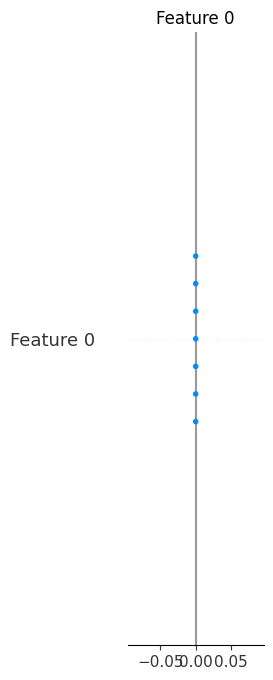

In [52]:
import pickle
import shap
import numpy as np

# Load your LSTM model from the pickle file
with open('/content/drive/MyDrive/AML 2304/best_lstm_model.pkl', 'rb') as f:
    model = pickle.load(f)

# Define a custom predict function
def predict_fn(x):
    # Reshape x to have a sequence length of 1
    x_reshaped = np.expand_dims(x, axis=1)
    return model.predict(x_reshaped)

# Ensure X_train_reshaped is a numpy array
X_train_reshaped = np.array(X_train_reshaped)

# Reshape X_train_reshaped if needed
X_train_reshaped = X_train_reshaped.reshape(X_train_reshaped.shape[0], -1)

# Sample a subset of your training data
sample_size = 7  # Specify the number of samples you want to process
indices = np.random.choice(X_train_reshaped.shape[0], sample_size, replace=False)
X_train_subset = X_train_reshaped[indices]

# Initialize the SHAP KernelExplainer with summarized background data using kmeans
background_data = shap.kmeans(X_train_subset, 7)
explainer_train = shap.KernelExplainer(predict_fn, background_data)

# Calculate SHAP values for your training data subset
shap_values_train_subset = explainer_train.shap_values(X_train_subset)

# Plot the SHAP values for the training data subset
shap.summary_plot(shap_values_train_subset, features=X_train_subset)

# LSTM based SVM

## imports

In [ ]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, SpatialDropout1D
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

## Feature Extraction from LSTM

In [ ]:
'''# Extracting features from the LSTM layer
feature_extractor = Model(inputs=best_lstm_model.input, outputs=best_lstm_model.layers[0].output)'''

from tensorflow.keras.models import Model

# Extract features from the LSTM layer
X_train_lstm = best_lstm_model.extract_features(X_train_reshaped)
X_test_lstm = best_lstm_model.extract_features(X_test_reshaped)

125/125 [==============================] - 1s 3ms/step


## Reshaping LSTM inputs in 2D for feed in to SVM Model

In [ ]:
print("X_train_lstm shape:", X_train_lstm.shape)
print("X_test_lstm shape:", X_test_lstm.shape)

X_train_lstm shape: (16000, 64)
X_test_lstm shape: (4000, 64)


In [ ]:
# Reshape LSTM features for SVM
X_train_lstm_reshaped = X_train_lstm.reshape(X_train_lstm.shape[0], X_train_lstm.shape[1])
X_test_lstm_reshaped = X_test_lstm.reshape(X_test_lstm.shape[0], X_test_lstm.shape[1])

## Model initialization and training and predicting

In [ ]:
# Define the parameter grid
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [0.01, 0.1, 1, 10],
    'kernel': ['rbf', 'linear']
}

# Initialize the SVM Classifier
svm_classifier = SVC(probability=True, random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=svm_classifier, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

# Fit GridSearchCV to the training data
grid_search.fit(X_train_lstm_reshaped, y_train)

# Print the best parameters found by GridSearchCV
print("Best Parameters:", grid_search.best_params_)

# Use the best estimator from GridSearchCV to make predictions
best_svm_classifier = grid_search.best_estimator_
y_train_pred_svm_tuned = best_svm_classifier.predict(X_train_lstm_reshaped)
y_test_pred_svm_tuned = best_svm_classifier.predict(X_test_lstm_reshaped)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
Best Parameters: {'C': 0.1, 'gamma': 0.1, 'kernel': 'rbf'}


## TL SVM Model Evaluation

In [ ]:
# Evaluate the tuned SVM model
print("Tuned SVM Accuracy on Training Set:", accuracy_score(y_train, y_train_pred_svm_tuned))
print("Tuned SVM Accuracy on Test Set:", accuracy_score(y_test, y_test_pred_svm_tuned))

# Calculate metrics
precision = precision_score(y_test, y_test_pred_svm_tuned)
recall = recall_score(y_test, y_test_pred_svm_tuned)
f1 = f1_score(y_test, y_test_pred_svm_tuned)
conf_matrix = confusion_matrix(y_test, y_test_pred_svm_tuned)

# Print metrics
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)
print("Confusion Matrix:\n", conf_matrix)

Tuned SVM Accuracy on Training Set: 0.9990625
Tuned SVM Accuracy on Test Set: 0.6205
Precision: 0.6418383518225039
Recall: 0.5912408759124088
F1-score: 0.6155015197568389
Confusion Matrix:
 [[1267  678]
 [ 840 1215]]


# Comparison of custom LSTM model and Transfered learnt SVM model based on custom LSTM

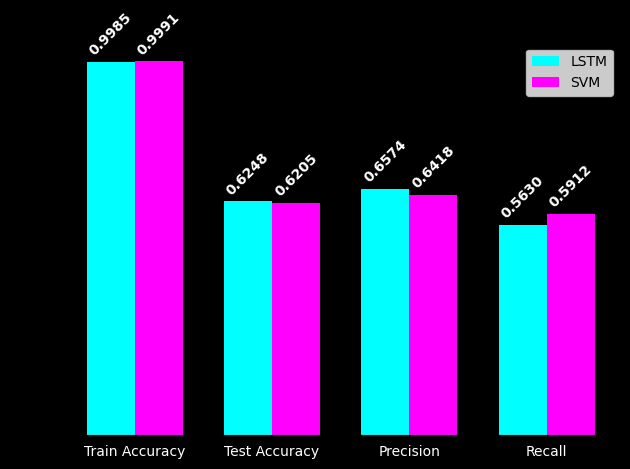

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import precision_score, recall_score, accuracy_score

# Calculate metrics for LSTM model
lstm_train_accuracy = accuracy_score(y_train, y_train_lstm_pred)
lstm_test_accuracy = accuracy_score(y_test, y_test_lstm_pred)
lstm_precision = precision_score(y_test, y_test_lstm_pred)
lstm_recall = recall_score(y_test, y_test_lstm_pred)

# Calculate metrics for SVM model
svm_train_accuracy = accuracy_score(y_train, y_train_pred_svm_tuned)
svm_test_accuracy = accuracy_score(y_test, y_test_pred_svm_tuned)
svm_precision = precision_score(y_test, y_test_pred_svm_tuned)
svm_recall = recall_score(y_test, y_test_pred_svm_tuned)

# Find maximum values for each metric for both models
max_train_accuracy_lstm = lstm_train_accuracy
max_test_accuracy_lstm = lstm_test_accuracy
max_precision_lstm = lstm_precision
max_recall_lstm = lstm_recall

max_train_accuracy_svm = svm_train_accuracy
max_test_accuracy_svm = svm_test_accuracy
max_precision_svm = svm_precision
max_recall_svm = svm_recall

# Create labels and metrics arrays for both models
labels = ['Train Accuracy', 'Test Accuracy', 'Precision', 'Recall']
lstm_metrics = [lstm_train_accuracy, lstm_test_accuracy, lstm_precision, lstm_recall]
svm_metrics = [svm_train_accuracy, svm_test_accuracy, svm_precision, svm_recall]
max_values_lstm = [max_train_accuracy_lstm, max_test_accuracy_lstm, max_precision_lstm, max_recall_lstm]
max_values_svm = [max_train_accuracy_svm, max_test_accuracy_svm, max_precision_svm, max_recall_svm]

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, lstm_metrics, width, label='LSTM', color='cyan')
rects2 = ax.bar(x + width/2, svm_metrics, width, label='SVM', color='magenta')

# Add annotations for maximum values
for i, v in enumerate(max_values_lstm):
    ax.text(i - width/2, v + 0.01, f'{v:.4f}', ha='center', va='bottom', color='white', fontweight='bold', rotation=45)
for i, v in enumerate(max_values_svm):
    ax.text(i + width/2, v + 0.01, f'{v:.4f}', ha='center', va='bottom', color='white', fontweight='bold', rotation=45)

ax.set_ylabel('Scores')
ax.set_title('Comparison of LSTM and SVM Models')
ax.set_xticks(x)
ax.set_xticklabels(labels, color='white')  # Set labels color to white
ax.legend()

# Set background color
fig.patch.set_facecolor('black')
ax.set_facecolor('black')

fig.tight_layout()

plt.show()

# SVM

## initializing SVM and making train test split

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split

X = combined_matrix_combined
y = df['label']# Target variable

In [ ]:
# Splitting the dataset into the Training set and Test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initializing the SVM Classifier
svm_classifier = SVC(probability=True, kernel='rbf', random_state=42)

# Training the model on the training set
svm_classifier.fit(X_train, y_train)

# Making predictions on the training set
y_train_pred = svm_classifier.predict(X_train)

# Making predictions on the test set
y_test_pred = svm_classifier.predict(X_test)

## SVM Evaluation

In [ ]:
# Calculate accuracies
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

# Print accuracies
print("Train Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)

# Calculate metrics
precision = precision_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)
conf_matrix = confusion_matrix(y_test, y_test_pred)

# Print metrics
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)
print("Confusion Matrix:\n", conf_matrix)

Train Accuracy: 0.802375
Test Accuracy: 0.6215
Precision: 0.6467889908256881
Recall: 0.5567620927936822
F1-score: 0.5984084880636605
Confusion Matrix:
 [[679 308]
 [449 564]]


In [ ]:
from lime import lime_tabular

# Convert feature names to strings
feature_names_str = [str(i) for i in range(X_train.shape[1])]

# Initialize LIME explainer
explainer = lime_tabular.LimeTabularExplainer(X_train.toarray(),
                                              feature_names=feature_names_str,
                                              class_names=['Non-Sarcastic', 'Sarcastic'],
                                              discretize_continuous=True)

# Define function to explain predictions for multiple instances
def explain_predictions(instance_indices):
    for idx in instance_indices:
        instance = X_test.toarray()[idx]
        explanation = explainer.explain_instance(instance, svm_classifier.predict_proba, num_features=10)
        explanation.show_in_notebook()

# Explain predictions for 10 specific instances (e.g., indices 0 to 9)
instance_indices = range(5)
explain_predictions(instance_indices)

# RF Classifier

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import tensorflow as tf

#'labels' is a binary column indicating sarcasm (1) or not sarcasm (0)
X = combined_matrix_combined
y = df["label"]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Defining and training the RandomForestClassifier
rf_classifier = RandomForestClassifier(n_estimators=250, random_state=42)
rf_classifier.fit(X_train, y_train)

# Make predictions
y_train_pred = rf_classifier.predict(X_train)
y_test_pred = rf_classifier.predict(X_test)

# Calculate the accuracy of the model on training set
train_accuracy = accuracy_score(y_train, y_train_pred)
print("Train Accuracy:", train_accuracy)

# Calculate the accuracy of the model on test set
test_accuracy = accuracy_score(y_test, y_test_pred)
print("Test Accuracy:", test_accuracy)

Train Accuracy: 1.0
Test Accuracy: 0.6045


**Evaluating the RF Classifier**

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Calculate predictions
y_pred = rf_classifier.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Calculate precision
precision = precision_score(y_test, y_pred)
print("Precision:", precision)

# Calculate recall
recall = recall_score(y_test, y_pred)
print("Recall:", recall)

# Calculate F1-score
f1 = f1_score(y_test, y_pred)
print("F1-score:", f1)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)


Accuracy: 0.6045
Precision: 0.62117903930131
Recall: 0.5616979269496545
F1-score: 0.589942975635044
Confusion Matrix:
 [[640 347]
 [444 569]]


**Model Interpretability using LIME (Local Interpretable Model-agnostic Explanations):**

In [ ]:
# Check the type of values in the label column
label_types = set()
for val in df["label"]:
    label_types.add(type(val))

print("Types present in label column:", label_types)

# Check if the label column has values other than 0 and 1
unique_values = set(df["label"])
if len(unique_values - {0, 1}) > 0:
    print("Label column has values other than 0 and 1.")
else:
    print("Label column only has values 0 and 1.")


Types present in label column: {<class 'int'>}
Label column only has values 0 and 1.


In [ ]:
from lime import lime_tabular

# Convert feature names to strings
feature_names_str = [str(i) for i in range(X_train.shape[1])]

# Initialize LIME explainer
explainer = lime_tabular.LimeTabularExplainer(X_train.toarray(),
                                              feature_names=feature_names_str,
                                              class_names=['Non-Sarcastic', 'Sarcastic'],
                                              discretize_continuous=True)

# Define function to explain predictions for multiple instances
def explain_predictions(instance_indices):
    for idx in instance_indices:
        instance = X_test.toarray()[idx]
        explanation = explainer.explain_instance(instance, rf_classifier.predict_proba, num_features=10)
        explanation.show_in_notebook()

# Explain predictions for 5 specific instances
instance_indices = range(5)
explain_predictions(instance_indices)

# Naive Bayes

## Initializing Naive Bayes and doing Train test Split

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split
import scipy.sparse as sp
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'alpha': [0.1, 0.5, 1.0, 2.0, 5.0, 10.0],  # alpha values to try
    'fit_prior': [True, False]  # fit_prior values to try
}

# Clip negative values to 0
X_clipped = combined_matrix_combined.maximum(0)

# Convert to dense array if needed
if sp.issparse(X_clipped):
    X_clipped = X_clipped.toarray()

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_clipped, y, test_size=0.2, random_state=42)

# Initialize Naive Bayes classifier
nb_classifier = MultinomialNB()

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=MultinomialNB(), param_grid=param_grid, cv=5)

# Perform the grid search
grid_search.fit(X_train, y_train)

# Print the best parameters found
print("Best Parameters:", grid_search.best_params_)

# Get the best model
best_nb_classifier = grid_search.best_estimator_

# Predicting the Train and Test set results using the best model
y_train_pred = best_nb_classifier.predict(X_train)
y_test_pred = best_nb_classifier.predict(X_test)

Best Parameters: {'alpha': 0.1, 'fit_prior': False}


## NB Evaluation

In [ ]:
# Calculate accuracies
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

# Print accuracies
print("Train Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)

# Calculate metrics
precision = precision_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)
conf_matrix = confusion_matrix(y_test, y_test_pred)

# Print metrics
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)
print("Confusion Matrix:\n", conf_matrix)

Train Accuracy: 0.72375
Test Accuracy: 0.5995
Precision: 0.5990654205607476
Recall: 0.6327739387956565
F1-score: 0.6154584733557369
Confusion Matrix:
 [[558 429]
 [372 641]]


# Comparison of All 4 Models RF classifier, LSTM, SVM and Naive Bayes Classifier

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Define the models and their corresponding names
models = [rf_classifier, LSTMmodel, svm_classifier, best_nb_classifier]
model_names = ['Random Forest', 'LSTM', 'SVM', 'Naive Bayes']

# Initialize lists to store the metrics
train_accuracy = []
test_accuracy = []
precision = []
recall = []

# Calculate metrics for each model
for model in models:
    if model == LSTMmodel:
        X_train_reshaped = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
        X_test_reshaped = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
        train_accuracy.append(accuracy_score(y_train, np.round(model.predict(X_train_reshaped))))
        test_accuracy.append(accuracy_score(y_test, np.round(model.predict(X_test_reshaped))))
        precision.append(precision_score(y_test, np.round(model.predict(X_test_reshaped))))
        recall.append(recall_score(y_test, np.round(model.predict(X_test_reshaped))))
    else:
        train_accuracy.append(accuracy_score(y_train, model.predict(X_train)))
        test_accuracy.append(accuracy_score(y_test, model.predict(X_test)))
        precision.append(precision_score(y_test, model.predict(X_test)))
        recall.append(recall_score(y_test, model.predict(X_test)))

# Plotting
fig, ax = plt.subplots(figsize=(12, 6))
bar_width = 0.2
index = np.arange(len(models))

# Bar plots
rects1 = ax.bar(index, train_accuracy, bar_width, label='Train Accuracy')
rects2 = ax.bar(index + bar_width, test_accuracy, bar_width, label='Test Accuracy')
rects3 = ax.bar(index + 2 * bar_width, precision, bar_width, label='Precision')
rects4 = ax.bar(index + 3 * bar_width, recall, bar_width, label='Recall')

# Adding labels, title, and legend
ax.set_xlabel('Models')
ax.set_ylabel('Scores')
ax.set_title('Comparison of Model Performance')
ax.set_xticks(index + 1.5 * bar_width)
ax.set_xticklabels(model_names)
ax.legend()

# Highlighting maximum values
max_train_acc = max(train_accuracy)
max_test_acc = max(test_accuracy)
max_prec = max(precision)
max_rec = max(recall)

ax.annotate(f'Max Train Acc: {max_train_acc:.3f}', xy=(train_accuracy.index(max_train_acc), max_train_acc),
            xytext=(-20, 10), textcoords='offset points', arrowprops=dict(arrowstyle='->', connectionstyle='angle3'))
ax.annotate(f'Max Test Acc: {max_test_acc:.3f}', xy=(test_accuracy.index(max_test_acc), max_test_acc),
            xytext=(-20, 10), textcoords='offset points', arrowprops=dict(arrowstyle='->', connectionstyle='angle3'))
ax.annotate(f'Max Precision: {max_prec:.3f}', xy=(precision.index(max_prec), max_prec),
            xytext=(-20, 10), textcoords='offset points', arrowprops=dict(arrowstyle='->', connectionstyle='angle3'))
ax.annotate(f'Max Recall: {max_rec:.3f}', xy=(recall.index(max_rec), max_rec),
            xytext=(-20, 10), textcoords='offset points', arrowprops=dict(arrowstyle='->', connectionstyle='angle3'))

plt.tight_layout()
plt.show()

"import matplotlib.pyplot as plt\nimport numpy as np\n\n# Define the models and their corresponding names\nmodels = [rf_classifier, LSTMmodel, svm_classifier, best_nb_classifier]\nmodel_names = ['Random Forest', 'LSTM', 'SVM', 'Naive Bayes']\n\n# Initialize lists to store the metrics\ntrain_accuracy = []\ntest_accuracy = []\nprecision = []\nrecall = []\n\n# Calculate metrics for each model\nfor model in models:\n    if model == LSTMmodel:\n        X_train_reshaped = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])\n        X_test_reshaped = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])\n        train_accuracy.append(accuracy_score(y_train, np.round(model.predict(X_train_reshaped))))\n        test_accuracy.append(accuracy_score(y_test, np.round(model.predict(X_test_reshaped))))\n        precision.append(precision_score(y_test, np.round(model.predict(X_test_reshaped))))\n        recall.append(recall_score(y_test, np.round(model.predict(X_test_reshaped))))\n    else:\n        